<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Testing-to-see-how-well-metadata-alone-predicts-toxicity" data-toc-modified-id="Testing-to-see-how-well-metadata-alone-predicts-toxicity-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Testing to see how well metadata alone predicts toxicity</a></span></li></ul></div>

In [369]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet, RidgeCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import xgboost as xgb

In [370]:
df = pd.read_csv('train.csv')

In [371]:
df.shape

(159571, 8)

In [372]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [373]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [374]:
df['comment_text'] = df.comment_text.apply(lambda x: x.replace('\n',' '))

In [375]:
[comment for comment in df.comment_text if "\\" in comment]

["When you say irrigiation structure, what exactly do you mean? I live on an irrigated block which uses overhead sprinkers, and I'm not far from the nearest channel. Thye all look the same throughout Sunraysia. I've got a little spare time now to grab some more shots, though I don't think I'll get out as far as Dareton. Got any requests?  \\talk",
 'Welcome!  Hello, , and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Here are some pages that you might find helpful: The five pillars of Wikipedia How to edit a page Help pages Tutorial How to write a great article Manual of Style I hope you enjoy editing here and being a Wikipedian! Please sign your name on talk pages using four tildes (~~~~); this will automatically produce your name and the date. If you need help, check out Wikipedia:Questions, ask me on my talk page, or ask your question and then place {{helpme}} before the question on your talk page. Again, welcome!\xa0  \\talk',

In [376]:
df['total_toxic'] = df[df.columns[2:]].sum(axis=1)
df['is_toxic'] = [1 if cell != 0 else 0 for cell in df.total_toxic]
df['is_toxic_no_profanity'] = [1 if cell != 0 else 0 for cell in df[df.columns[[2, 3, 5, 6, 7]]].sum(axis=1)]

In [377]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_toxic,is_toxic,is_toxic_no_profanity
0,0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,0,0
3,0001b41b1c6bb37e,""" More I can't make any real suggestions on im...",0,0,0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,0,0


In [378]:
df[df.total_toxic > 2].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_toxic,is_toxic,is_toxic_no_profanity
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,4,1,1
42,001810bf8c45bf5f,You are gay or antisemmitian? Archangel WHit...,1,0,1,0,1,1,4,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,3,1,1
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0,4,1,1
56,0020fd96ed3b8c8b,=Tony Sidaway is obviously a fistfuckee. He lo...,1,0,1,0,1,0,3,1,1


In [379]:
df['question'] = [1 if '?' in comment else 0 for comment in df.comment_text]
df['exclamation'] = [1 if '!' in comment else 0 for comment in df.comment_text]
df['comment_text_char_only'] = [''.join(char for char in comment if char.lower() in 'abcedfghijklmnopqrstuvwxyz') for comment in df.comment_text]
df['comment_text_char_space'] = df.comment_text.apply(lambda x: ''.join([char for char in x if char.upper() in ' ABCDEFGHIJKLMNOPQRSTUVWXYZ']))

In [380]:
# generates a list of ids for which there are no alphabetical characters in the comments
empty_comments = [index for comment, index in zip(df.comment_text_char_space, df.id) if not sum(1 if char in comment.lower() else 0 for char in 'abcedfghijklmnopqrstuvwxyz')]

In [381]:
df[df.id.isin(empty_comments)].index

Int64Index([4482, 6300, 17311, 52442, 53787, 61758, 82681], dtype='int64')

In [382]:
df.drop(df[df.id.isin(empty_comments)].index, inplace=True)

In [383]:
for comment in df.comment_text_char_space:
    if len(comment) < 10:
        print(comment)
        print('-' * 10)

   May 
----------
  August 
----------
  August 
----------
Thanks 
----------
   Jan 
----------
 Dannyg  
----------
  August 
----------
GET IT 
----------
ps NAIR
----------
ISBN 
----------
Oppose 
----------
Whatever 
----------
You wish
----------
Agreed 
----------
 EST Apr
----------
Lovely   
----------
and then 
----------
MARDYKS 
----------
How sad  
----------
  talk
----------
Testing 
----------
Fuck off 
----------
 p u suck
----------
Fuck you
----------
 January 
----------
  March 
----------
Right 
----------
  March 
----------
   March 
----------
Also 
----------
   May
----------
You to 
----------
Floppy 
----------
  talk
----------
Fuck up 
----------
Bring it 
----------
or where
----------
   July
----------
Noted 
----------
unblockyo
----------
Why so 
----------
My bad
----------
Sarashi 
----------
What bot
----------
hes not 
----------
 Club  
----------
Agreed 
----------
Ditto 
----------
unbloc
----------
Thank you
----------
 August  
----------

In [384]:
for comment in df.comment_text_char_space:
    if len(comment.split()) == 1:
        print(comment)
        print('-'*len(comment))

   May 
-------
  January 
----------
      August
------------
   October 
-----------
talktalk  
----------
Thanks       
-------------
September 
----------
  December 
-----------
Apologies 
----------
TemplateNnwarn 
---------------
Copyright       
----------------
httpwwwimdbcomnamenmfilmoseriestt 
----------------------------------
  TalkContributions  
---------------------
  August 
---------
  August 
---------
Thanks 
-------
  January 
----------
   Jan 
-------
 Dannyg  
---------
  ftpftpmetfsuedupubweathertropicalGuamStuffWTPNPGTW 
-----------------------------------------------------
  August 
---------
cursorhelp   
-------------
  January 
----------
wwwebenefitsvagov
-----------------
ISBN 
-----
September 
----------
 TalkContributions  
--------------------
  January 
----------
Oppose 
-------
Whatever 
---------
Solution                              
--------------------------------------
  December 
-----------
allregionshtml     
-------------------
  October 

In [385]:
# prints words that have a capitalized character in them (usually means words are conjoined for some reason)
for comment in df.comment_text_char_space:
    if re.findall(r'[A-Z]*[a-z]+[A-Z][a-z]*', comment):
        print(re.findall(r'[A-Z]*[a-z]+[A-Z][a-z]*', comment))
# nothing too significant that requires cleaning

['WikipediaGoodarticlenominations']
['DuLithgow']
['ImageWonjujpg', 'ImageWonjujpg', 'ImageWonjujpg', 'ImageWonjujpg', 'WikipediaFair', 'WikipediaImage', 'tagsFair', 'WikipediaImage', 'WikipediaFair']
['TalkVoydan']
['nowDeepu']
['WikipediatalkWiki', 'ProjectClassicalmusic', 'ArchiveNeedhelp', 'WikipediatalkWiki', 'ProjectMusic', 'ArchiveIcouldusesomehelp', 'WikipediatalkWiki', 'ProjectMusic', 'ArchiveRaulbot', 'httpdiggcommusicWikipediahasfreeclassicalmusicdownloads']
['RfA', 'NoSeptembers', 'ElC']
['gaysGypsys']
['McDonald']
['BuckminsterFullercarbonnanotubes', 'HyperSkyhook', 'HyperSkyhook']
['McDickerson']
['TalkFrank']
['NeilNs']
['ThAt', 'ThAt', 'ThAt']
['httpwwwconstitutioniereportsConstitutionof']
['vandalisingxD']
['VfD', 'VfD', 'VfD']
['TalkJewishlobby', 'WPVcomparingJewish', 'VirtualLibraryand', 'DissidentVoice']
['httpwwwislamorgbrC']
['nonBelgium', 'followAnd']
['WeijiBaike']
['httpbooksgooglecombooksidH', 'HevU', 'GfpE', 'CpgP', 'AdqThiyyamatrilinealhlensa', 'XeiTlp', 'PU

['WikipediaNaming']
['unblockW']
['VoluntarySlave']
['MoP']
['alHusayni', 'CitizenArab']
['ThivierrRob']
['BlanchardbMy', 'EarsMy']
['WikipediaQuestions']
['talkHammersoft']
['CategoryLiving', 'WikiProject', 'WikiProject']
['UserLixxx', 'UserLixxx']
['SamsonMark', 'WileyV', 'McGill']
['ThuranX']
['ObjectOriented', 'ObjectOriented']
['BlackWhite', 'BlackWhite']
['WikipediaOwnership', 'WikipediaAssume']
['httpenwikipediaorgwikiWestern']
['WikipediaRequestsforcomment', 'RfC', 'TalkRossville', 'RfA']
['ImageP', 'ImageP', 'WikipediaUse', 'WikipediaImage', 'tagsNonfree']
['ReWhats']
['WikipediaQuestions']
['treatmentBy']
['WikipediaSockpuppet', 'investigationsNoormohammed']
['HumanRightsand', 'EqualOpportunity']
['ArbCom', 'ArbCom']
['DeGuire', 'DeGuire']
['BryanFrom']
['TalkD', 'WikipediaRequesting', 'TalkD', 'TalkD']
['ActiveRain', 'ActiveRain']
['FranoisXavier', 'JeanRen', 'JeanBernard', 'JeanLuc', 'LaffonParias', 'JeanMichel']
['WikipediaArticles', 'deletionRant', 'WikipediaArticles', 'd

['linkFrom']
['httpwwwyoutubecomwatchvurIbu']
['talkFlyer']
['soundsO']
['WikiProject']
['FileAgakhanpalacefrontview', 'FileAgakhanpalacefrontview', 'HelpImage']
['ImageDvcode']
['CounterVandalism']
['alKhwarizmis', 'UserLumos']
['UserW', 'AfD', 'WikipediaArticles', 'deletionQuantum', 'indvidualI', 'methodI']
['alAli', 'alShaikh', 'alAli', 'alArabi', 'alAli', 'alAli', 'alAli', 'alShahra', 'alHilwe', 'alAli']
['CategoryRomani']
['MacDonalds']
['WikipediaMiscellany', 'deletionUser']
['CoB', 'CoB']
['EastEnders']
['CfD']
['declineYes']
['UserMjpresson', 'UserMjpressons', 'OctoberNovember', 'UserMjpresson', 'UserMjpresson']
['yearAs']
['PubMed']
['TalkRotor']
['rmadBhgavatam']
['GeorgianJorjadze', 'FisherQueen', 'GeorgianJorjadze']
['talkClue']
['TalkWindows']
['WikiProject', 'classMain', 'PageB', 'backgroundcolorF', 'colorF', 'WikiProject', 'WikiProject']
['FinancialNorth', 'PaulH', 'FinancialNorthjpg', 'SanFrancisco', 'FinancialNorthjpg']
['RfC', 'TalkTurkey', 'RequestforComment', 'Sanit

['nonEnglish']
['talkKaiwhakahaere']
['OhyoubetterfollowwhatIdoor']
['notAnyways', 'YouTube']
['WikipediaRequests']
['TalkThe']
['WProjClassical']
['nonMuslims']
['proRussian']
['YouTube']
['WwwRamizwaptk']
['MisterSmiley']
['WGHoF']
['GlobeLieberman', 'DemocratA', 'LamontHe', 'CommitteeIm', 'saidHe', 'saidWith', 'WashingtonThey', 'saidDemocrats', 'RepublicansHe', 'seniorityIm', 'saidI', 'saidIn', 'RepublicansLieberman']
['HoganLita', 'UserVjmlhds', 'talkVjmlhdstalk']
['WikipediaQuestions', 'LaTe', 'LaTe']
['WikipediaQuestions', 'SatuSuro']
['ManBat']
['CommonsOversight', 'CommonsContact', 'usProblems']
['WikipediaQuestions', 'WikHead']
['CategoryArticles', 'CategoryUnreviewed', 'CategoryUnreviewed']
['TemplateNnwarn']
['HotCat']
['WhatWho', 'itI']
['WikiProject']
['BerasGoyco']
['RfC']
['talkPratyya', 'GhoshArchives']
['TalkGeorge']
['declinePlease']
['SharkD']
['TeliaSonera']
['ImageBwbuscardsmalljpg', 'ImageBwbuscardsmalljpg', 'WikipediaImages']
['TalkTurkey', 'DrK', 'differenthttps

['alQidah']
['MexicasUser']
['FileOntariolegev', 'FileOntariolegev', 'HelpImage']
['talkBlackashhave']
['YouTube', 'DownRight', 'YouTube']
['iM']
['SnakeintheEye']
['WikiProject']
['ipaN', 'WikipediaCategoriesfordeletion', 'LogAugust', 'CategoryWritingsystemscategories']
['UserFootballgy']
['HeadcheeseChord']
['FileCropped']
['daDanish']
['soYou', 'everyoneWhats']
['BelarusianUkrainian']
['FileRhythm']
['MaB']
['RitterBeauprez']
['DeepakAn', 'likeHe', 'WrongDeepak']
['AngloSaxon', 'AngloSaxon', 'AngloSaxon', 'preAnglo', 'AngloSaxon', 'AngloSaxon', 'NorseGaelic', 'AngloSaxon']
['editConservationist']
['PaxEquilibrium']
['httpenwikipediaorgwikiTalk', 'MountHood', 'ClimbingRecords', 'WikipediaWikipedia', 'ConsequencesHu', 'administrationSaffronx']
['nonEnglish']
['SpecialContributions']
['SuPe', 'WiL', 'LiVe', 'FoRe', 'VeR', 'iF', 'DoN', 'ReS', 'PeC', 'SuPe', 'WiL', 'PaT', 'HeTi', 'FooL', 'SuPe', 'WiL', 'LiVe', 'FoRe', 'VeR', 'iF', 'DoN', 'ReS', 'PeC', 'SuPe', 'WiL', 'PaT', 'HeTi', 'FooL'

['aAdam', 'bThe']
['ImageDetroit', 'TigersDjpgpx']
['kingsTutankhamun']
['TalkWest', 'LineDistances']
['SpencerLeese']
['importScript', 'UserMr', 'ZmanrollbackSummaryjs']
['CocaCola', 'CocaCola']
['deDatei', 'TalkC', 'ServicesNewtimetables']
['WikipediaQuestions']
['McLeish']
['SDmicroS', 'SDmicroS']
['ImageHilary']
['intendedStani']
['UserEmerson']
['WikipediaArticles', 'deletionList', 'WikipediaArticles', 'deletionList']
['WikipediaReference', 'deskScience']
['TalkJules', 'VerneCouplechanges']
['WikipediaRequests', 'adminshipBaseball', 'UserEveryme']
['CommonsCommons', 'BotsRequests']
['talkArticles', 'creationHotel', 'TalkContribs']
['WikipediaQuestions']
['credentialsLou']
['UserPurrum']
['imagedetailsA']
['TalkRobert', 'StoepelEdit']
['noticeboardIncidents']
['TalkAlapainui']
['talkAnoshirawan']
['FitzGerald', 'nonAmerican']
['WikipediaAutobiography']
['LingNut']
['articleExpert']
['AfD', 'WikipediaArticles', 'deletionSubversion']
['FathlessY']
['JTMcDonald']
['TalkEcumenopolis']


['talkGeneral', 'ElectricAll']
['NormanAnglo', 'HormanFlemish', 'MacPhersonsthis', 'MacPhersons', 'MacPhersons']
['MacKay']
['UserRinpoche']
['CategoryReal']
['classTalk', 'WikiProject', 'WikiProject', 'WikipediaContributing']
['UserAskolnicks']
['TeutonicTamer']
['InaMaka']
['ArbComs']
['CentreLeft']
['CategoryFictional']
['WikipediaStub']
['ImageGodofwarkratosjpg', 'ImageGodofwarkratosjpg', 'WikipediaFair']
['TalkNorth']
['UserAnonmous', 'AlasdairGreen']
['heritageWhich', 'stationsWe', 'AfricaJ', 'UristActivistmariageetc', 'SamuelDba', 'MbaPgdm', 'PgdtheoPgdrskfbscfinstmmfacmmicmcacimuk']
['UserBalkan', 'historyThey', 'nationalismexpandismThey', 'userKhoikhoi', 'userFuture', 'userFuture', 'userKhoikhoi', 'userAldux', 'userKhoikhoi', 'userTekleni', 'userTelex', 'userNiko', 'userEuthymios', 'userKhoikhoi', 'userFuture', 'userEuthymios', 'userKhoikhoi', 'userFuture', 'userHectorian', 'userPolitis', 'AndreasJ', 'userKhoikhoi', 'userAldux', 'userMiskin']
['UserKeitaadama']
['AfD']
['Wikip

['UserRovoam', 'UserRovoam', 'NagornoKarabakh', 'KuraAraxes', 'TemplateEurope', 'UserTabib', 'UserTony', 'talkRdsmith', 'talkCrypto', 'UserWeyes', 'UserDante', 'UserChanting', 'NagornoKarabakh', 'UserTony', 'UserCodex', 'UserIsomorphic', 'UserWho', 'UserDbachmann', 'TalkUrartu', 'TalkNagorno', 'TalkCaucasian']
['theRevolutions']
['SandyGeorgia']
['outSiemgi']
['DoB', 'DoD', 'DoB', 'DoD', 'BadenBaden', 'BadenBaden']
['nonN']
['WikipediaArbitration', 'RequestsCase']
['UserTalk', 'DeltaQuad']
['McGill', 'AntiVandalism', 'MerriamWebster']
['FPaS']
['WikiProject']
['alSadrs']
['TalkKatherine']
['WikipediaWhere']
['httpenwikipediaorgwikiWikipedia']
['BritishBattles']
['ArbCom']
['proIsrael']
['httpenwikipediaorgwindexphptitleNissan']
['JediLofy']
['TalkTerry', 'TalkTerry', 'TalkTerry']
['JustPhil']
['TemplateInfobox']
['HkanTirgil']
['DetachmentDelta']
['ChicosBail', 'AmiDaniel', 'ChicosBail', 'AmiDaniel', 'AmiDaniels', 'YourCousin']
['NetB', 'NetB']
['RfC', 'RfC', 'antiDominionist']
['etcI'

['WikipediaAdministrator']
['JzG']
['PoppaBalloon']
['KatsChernins']
['TalkCrown']
['ComeBack']
['ArbCom']
['WikiGod']
['ChatR']
['WikipediaPeer', 'WikipediaPeer', 'reviewCapon']
['vodkaRed']
['WikiProject']
['AlexHoratiuss']
['PhilKnight']
['WikipediaExternallinks', 'userDandelion', 'RfC', 'WikipediaRequestsforcomment', 'SocietyClaw']
['UserPablo']
['TheTrap', 'TalkThe']
['UserDominick', 'httpenwikipediaorgwikiWikipedia', 'RequestsforcommentDominick']
['TalkBlackpool']
['JadeYomiel', 'JadeYomiel']
['talkStrothra']
['DrWinterbergs']
['WikipediaRequests', 'adminshipKeilana']
['WikipediaNo', 'WikipediaVerifiability', 'WikipediaCite']
['IsraelPalestinian', 'AlAqsa', 'AlAqsa', 'AlAqsa', 'ArabIsraeli']
['LoveMonkey']
['httpenwikipediaorgwikiUsertalk']
['EnglandBristol', 'DeVirgas', 'DeVirgas', 'CorteReal', 'IndoSumerians', 'VenetianDalmatian', 'PedroLisbon', 'PhD', 'inRehabilitation', 'inRehabilitation']
['WikipediaWiki']
['TalkJapanese']
['MercedesBenz', 'MotorCoup']
['WikiProject', 'WikiP

['ImageJeffreysachsjpg', 'ImageJeffreysachsjpg', 'WikipediaFair', 'WikipediaImage', 'tagsFairuse', 'WikipediaImage']
['MariahYulia']
['FilePac']
['PortalBiography']
['AfD', 'RfC']
['WikiProject']
['ideaIt', 'forksBest', 'onlyBesides', 'viewsAs']
['shieldsCaldwell', 'phosphorusMc']
['AbsolutDan', 'SectCult']
['GunMetal']
['UserThe', 'OwlThe']
['UserAkraj']
['UserThe']
['fineI', 'yaddaI']
['TemplateInfobox', 'CoA']
['ImageBattmapgif', 'ImageBattmapgif']
['RfC']
['MinnanTaiwanese']
['AttributionShare']
['httpsenwikipediaorgwikiTalk', 'SegaGenesis']
['RfC', 'RfC']
['McEntire', 'McEntire', 'TalkReba', 'McEntire']
['BlackCab', 'BlackCab']
['CanadianLinux']
['TalkbackChallengethelimits']
['alKhwarizmi']
['AfD', 'WikipediaArticles', 'deletionChina']
['InShaneee']
['interWiki']
['antiIslamic']
['YouTube']
['riceHey', 'riceHey', 'riceHey', 'riceHey', 'riceHey', 'riceHey', 'riceHey', 'riceHey', 'riceHey', 'riceHey', 'riceHey', 'riceHey', 'riceHey', 'riceHey', 'riceHey', 'riceHey', 'riceHey', 'ric

['ImageUnion', 'ImageUnion']
['httpwwwftddepolitikdeutschlandWeniger', 'EinwohnerStatistikerlassen']
['ImageAntgif', 'ImageAntgif', 'WikipediaImage', 'WikipediaImage', 'WikipediaMedia', 'RfC', 'antiSoviet', 'userProhibit']
['oneWhitehorse']
['WikipediaImages']
['TalkRequest', 'UserZy']
['WikipediaCopyright']
['herehttpenwikipediaorgwikiLegalstatusof', 'InternetpornographyUnited']
['WikipediaConflict']
['TalkKevin']
['TalkSiemens']
['HelpFootnotes', 'HelpFootnotes', 'HelpFootnotes', 'TalkCooling']
['ContributionsI']
['WikipediaTemplates', 'deletionTemplate', 'TemplateInfobox', 'WikipediaRequests']
['ChatNoir']
['AhDiyako']
['antiGreek', 'ethnicGreek']
['MaryAnne']
['MySpace', 'BungaloUniversal', 'LaToya', 'LaBelle', 'httpradiodisneygocommusicincubatorI', 'WikipediaArticles', 'WikipediaArticles', 'deletionProperty', 'noteYes']
['RfA', 'WikipediaRequests', 'adminshipBob']
['WikipediaAdministrators', 'noticeboardIncidents']
['httpsenwikipediaorgwikiOscar', 'WildeImprisonment', 'httpsenwiki

['DanielBryant']
['MaGio']
['WikipediaQuestions']
['FranceU']
['TalkMadurai']
['McQueeny']
['WikipediaCiting', 'WikipediaCitation']
['TalkGeorgian']
['httpenwikipediaorgwindexphptitleUsertalk', 'StillStandingoldid']
['talkI']
['NewPhyrexia', 'talkPrabash']
['WikipediaWhere', 'welcomeR']
['differenceSimply']
['SummerSlam']
['TalkClodius']
['FileThere', 'FileThere', 'WikipediaFiles']
['YouveGot']
['LittleMountain']
['FileBenztropinepng', 'FileBenztropinepng', 'WikipediaFiles']
['dAmecourt', 'dAmecourt', 'dAmecourts']
['TushekSpigel']
['PacificWarrior']
['InGame']
['oPt', 'oPt']
['httpsenwikipediaorgwikiRacism']
['nonEnglish', 'httpeigawikiacomwikiTalk', 'HumanityandPaper', 'BalloonsNameofthesellerofgoldfish']
['WikipediaArticles', 'deletionList']
['EuropeAustralia']
['UserN', 'UserN', 'UserN', 'UserN', 'UserN', 'UserN', 'UserN', 'UserN', 'UserN', 'UserN', 'UserN', 'UserN', 'UserN', 'UserN', 'UserN', 'UserN', 'UserN', 'UserN', 'UserN', 'UserN', 'UserN', 'UserN', 'UserN', 'UserN', 'UserN',

['McAndrew', 'McAndrew']
['TalkS']
['TemplateBooks', 'UserAlastair', 'TemplateBooks']
['WikiProject']
['nonMuslim']
['McDogm', 'McDogm']
['SpongerJack', 'SpongerJacks']
['NickThirteen', 'NickThirteen']
['PoS']
['WarthogDemon']
['httpsenwikipediaorgwikiUser', 'CrazyAces', 'JeromeMackey']
['biT']
['GovernorGeneral']
['SuperEarth', 'GammaRay', 'FarInfrared', 'GrAnd', 'LunarEx', 'NoachianMars', 'DuneXpress', 'CrossScale', 'DynaM', 'MetNet']
['EnglishIrish']
['MiB']
['WPFootnotesCitingafootnotemorethanonce']
['WikipediaSimplified', 'WikipediaNeutral']
['WikipediaNo']
['httpenwikipediaorgwikiTalk', 'MuhammadalDurrah', 'NPOVinlightoftheKarsentyverdict']
['WikipediaR', 'FunkyFlytalk']
['AtTawba']
['RfA']
['TalkContribsproblem']
['FileE']
['PalmdaleLancaster', 'OdettMarkham', 'MacKenzie']
['PageHow', 'MachineHe', 'SunsetsA', 'EyeHe', 'ItHe', 'CompetitionHe', 'GrowIt', 'WashedIt', 'CutIt', 'SauceHis', 'DischargedHe', 'SoonSo']
['HelenOnline']
['ReBlocks']
['CategoryCompanies', 'CategoryCompanies

['CenLamar', 'httpsenwikipediaorgwindexphptitleSteve']
['UserMakedonas', 'UserNestore', 'UserVergina', 'UserMakedonas']
['panSerbian']
['ImagePablo', 'ImagePablo', 'WikipediaFair', 'WikipediaImage', 'tagsFair', 'WikipediaImage', 'WikipediaFair']
['WikipediaSockpuppet', 'investigationsHerb']
['GlassSteagall']
['ClueBot', 'ClueBot', 'TalkContribs']
['enoughhttpwwwamazoncomSoviet', 'RussianArtillery', 'DesignPracticesdprefsrie']
['interestI', 'opinionAlso', 'answerBy']
['WikipediaRequests', 'feedbackArchive']
['SunburnWell']
['usernameCo']
['TalkPennine']
['httpenwikipediaorgwikiWikipedia', 'NOTWikipediaisnotablogC', 'WebhostingserviceCsocialnetworkingservice']
['RfA']
['bowlI', 'themGermanshepherds']
['TalkSir']
['citationPeople']
['EngineerThe']
['AutoWiki', 'CategoryWikipedians']
['TalkContribs']
['insertedI']
['talkPrabash']
['MerriamWebster', 'PhD', 'SeptOct', 'quoteN']
['TalkPride']
['McDougal']
['WikiProject', 'WikiProject']
['McCune', 'McCune', 'WikipediaChanging']
['etcBoth']
['S

['youCategory']
['ArchiveNovember']
['ImageDestroyer', 'ImageDestroyer', 'WikipediaImage', 'tagsFairuse', 'WikipediaImage']
['ImageBattleofhaengjujpg', 'ImageBattleofhaengjujpg', 'AttributionShare', 'WikipediaMedia']
['WikipediaAutobiography', 'WikipediaNeutralpointofview', 'TalkTony', 'TalkTony', 'WikipediaNeutralpointofview', 'TalkTony']
['MeatCommand', 'FleetCommand']
['RobertG', 'MichaelIs']
['httpenwikipediaorgwikiTalk', 'HinduismandtheSikh', 'PanthSources']
['paradoxesEconomy']
['antiUnionismseparatism']
['ShangriLa', 'userRobertect', 'userE', 'visitShugden']
['httpenwikipediaorgwikiHugo', 'httpenwikipediaorgwikiThomas', 'httpenwikipediaorgwikiFrank', 'httpenwikipediaorgwikiEarnie']
['ImageAgatha', 'ImageAgatha', 'WikipediaFair', 'WikipediaImage', 'tagsFairuse', 'WikipediaImage']
['WikipediaTemplate', 'messagesSources', 'articlesGeneric']
['BourbonParma']
['wrongI', 'LeTziyon']
['deletionSeth']
['MediaExampleogg', 'MediaExampleogg', 'textSuperscript', 'textSmall', 'titleLink', 't

['httpwwwhungarianreferencecomHungariannamedaynevnapmagyarnvnapoknevnapokaspx']
['inJinnai']
['IrishU']
['antiAmerican']
['WikipediaAdministrator']
['FantastiCar', 'FantastiCar']
['PhD']
['SouthcarolinaSportsin', 'SouthCarolina']
['nonP']
['WikipediaDeletionreview', 'LogMarch', 'EncyclopediaDramatica']
['TalkStalk']
['SineBot']
['badQ']
['NaziSoviet']
['TalkList', 'cultsRemoved']
['WikipediaArticles', 'deletionRobert', 'WikipediaDeletion', 'policyCourtesy']
['TalkChord']
['WikipediaFeatured', 'candidatesRihanna']
['EgyptianFinnish']
['httpwwwgeforcecomNewsarticlessuperstreetfighterivarcadeeditioncomingtothepcthisjuly']
['xD']
['NukeH', 'MsTopeka', 'httpenwikipediaorgwikiWikipedia', 'httpenwikipediaorgwikiUser']
['JamesDsquierjpg']
['NickNite', 'NickNite']
['ThuranX', 'ThuranX']
['FreemasonrywatchO']
['ecI']
['declineDont']
['McCabe']
['ImmigrationtoMexico']
['DumbDrax']
['WikiProject']
['TalkCraig']
['WikipediaSock', 'puppetProposal', 'WikipediaTemplate', 'talkExpansion', 'WikipediaTem

['TemplateUser']
['httpsenwikipediaorgwikiDesnos', 'ToussaintYed']
['songThe']
['AfD']
['httpenwikipediaorgwindexphptitleIsraeli', 'WestBankbarrierdiffoldid', 'httpwwwnadploorgfactswallWall']
['PostAf', 'AfD', 'AfD', 'AfDs']
['TalkLove']
['httpdirectorygooglecomTop', 'ReferenceEducation', 'EducatorsPlagiarism', 'httpwwwjiscpasacukapppagecgiU', 'UrbanaChampaign', 'InfoTrac', 'WordC', 'WordC', 'WordC', 'RockwellKincanon']
['YearAaron']
['ImageAtlas', 'RockefellerCenterjpg', 'ImageAtlas', 'RockefellerCenterjpg', 'WikipediaPossibly', 'WikipediaPossibly']
['RfA', 'RfA']
['talkNaming']
['httpssecurewikimediaorgwikipediaenwindexphptitleSpecial', 'RenameUserreason', 'WPUSURPoldusernameFlynxnewusername', 'FlynxusurpedsuppressRedirect']
['ImageWoodydurhamjpg', 'ImageWoodydurhamjpg']
['ImageAquamandavisjpg', 'ImageAquamandavisjpg', 'WikipediaImage', 'tagsFairuse']
['WikipediaStub']
['enwikiquoteorgwikiAge']
['wikiSpecial', 'CheckUser', 'wikiSpecial', 'LogmovepageUser', 'wikiSpecial', 'Logblockpag

['CategoryImages']
['AjaxSmack']
['cleanupdateX', 'wikifydateX']
['TalkCs']
['WikipediaArticles', 'deletionJebi']
['ArnieGinsburg', 'discountedAdam']
['PresidentElect']
['WikipediaQuestions']
['NoBlast']
['PlayStation', 'PlayStation']
['McVeigh']
['didI', 'guysPoints']
['AfD']
['httpsenwikipediaorgwindexphptitleTalk']
['McCoy', 'McCoy']
['AvengersComics']
['GeorgianSouth']
['JulyAugust', 'IdolBig']
['CategoryNevada']
['ImageMatt']
['BrixtonBusters']
['TalkHeather']
['YouTube', 'CoroCoro', 'YouTube']
['seeW', 'MacInnis']
['ImageIzvoriste', 'ImageIzvoriste']
['declineWhat']
['CategoryPseudoscience']
['WikipediaQuestions']
['haShem']
['ApJ']
['ColemanWeinberg']
['httpwwwprowrestlingnetartmanpublishW']
['ArchDebunker']
['McClenon', 'mcClenon']
['HiUser', 'ArticleAs', 'BoricuaStar', 'suspiciousHe']
['TalkScenes', 'TalkScenes']
['aL']
['stylebackgroundcolorF', 'backgroundcolorF', 'stylebackgroundcolorF', 'backgroundcolorF', 'classMain', 'PageB', 'backgroundcolorF', 'backgroundcolorF']
['well

['dicksI']
['ChartData', 'MRangemetersDropinches', 'RangemetersDropinches']
['RsyncDot', 'RsyncNetwebsite']
['WikipediaSignatures']
['YouReally', 'AfDed']
['TalkOilforfood']
['WikipediaWiki', 'ProjectNovels', 'PercyJacksontaskforce']
['IsraelianPalestian']
['KuntopfSockpuppets']
['WikipediaSandbox']
['HighKing', 'antiBritish']
['easyRocky']
['BlanchardbMy', 'EarsMy']
['talkDid', 'JamieS']
['PrizeRebel', 'MapleStory', 'xBox', 'xBox', 'xBox', 'xBox', 'xBox', 'xBox', 'xBox', 'NunChuck', 'MapleStory', 'MySpace', 'MySpace', 'MySpace', 'MySpace', 'MySpace', 'YouTube', 'MySpace', 'MySpace', 'PayPal', 'YouTube', 'PayPal', 'YouTube', 'MySpace']
['antiIsrael', 'antiU', 'DollarWall', 'httpwwwmarxsitecomGlobal', 'httpwwwamazoncomGlobal', 'GambleWashingtons', 'FaustianDominancedp', 'httpenwikipediaorgwikiAhmed', 'ZakiYamani']
['TalkContribs']
['talkExpert']
['WikipediaTopical']
['DoncramGeorge', 'SalisburyGeorge', 'SalisburyGeorge']
['RavenTaylor']
['EncMstr']
['talkDutch']
['WikiNazi']
['CavalliSf

['ImageCourt', 'ImageCourt', 'WikipediaFair', 'WikipediaImage', 'tagsFair', 'WikipediaImage', 'WikipediaFair']
['RfC', 'RfC', 'TalkList', 'journalsR']
['AfD', 'WikipediaDeletion', 'talkAnna', 'FrodesiakRequesting']
['accountsI']
['MisterFusion']
['WikipediaSandbox']
['TemplateQuranusc', 'TemplateBukhariusc', 'TemplateQuranuscnum', 'TemplateQuranuscnumrange', 'TemplateBuhari']
['NeoSoul', 'NeoSoul', 'NeoSoul', 'CalypsoSoca', 'NeoSoul', 'NeoSoul']
['articlerefrencehttpenwikipediaorgwikiFolly', 'WildlifeRescue']
['WikipediaSuspected', 'puppetsLuluofthe', 'LotusEaters']
['PattiParker']
['SoftwareProduct', 'WikipediaUndeletionpolicy']
['EndlessDan']
['WikipediaFeatured', 'candidatesList']
['PortSalut']
['SarekOf']
['ElinorD', 'TeaDrinker']
['treasureValli']
['userSam', 'userWangi']
['httpenwikipediaorgwikiFile']
['BracketBot', 'SpiritedMichelle', 'UserA', 'UserDruof', 'UserLegoktm', 'UserBgwhite', 'BracketBot', 'SpiritedMichelle']
['DoE', 'MeV', 'MeV', 'MeV']
['declineSame']
['TalkAngel']
[

['ArticleI', 'ConstitutionU']
['stylebackgroundcolorF', 'classMain', 'PageB', 'WikiProject', 'WikiProjects', 'classMain', 'PageB', 'classMain', 'PageB', 'backgroundcolorSeashell', 'backgroundcolorSeashell', 'WikipediaAdo']
['WikipediaSockpuppet', 'investigationsEthan', 'CraigleaArchive', 'CategorySuspected']
['NonAdmin']
['WikipediaQuestions']
['httpiimgurcomomsJ', 'httpiimgurcomtXc', 'httpiimgurcomTry', 'httpiimgurcomO', 'VerdyPs']
['TalkAurea', 'CruzMisuse']
['IndoEuropean']
['httpwwwreferencecombrowsewikiSandinista', 'NationalLiberation']
['antiJewish']
['SoapCentral']
['CategoryFilms', 'CategoryFilms']
['DtotheMtothe', 'KoolAid']
['FileI', 'SAtlantiumStampgif', 'FileI', 'SAtlantiumStampgif', 'WikipediaFiles']
['WikipediaWhere', 'talkThe', 'OldJacobitemy']
['httpwinnipediacawikiProject', 'TalkProject', 'WikipediaRequesting', 'TalkProject', 'TalkProject']
['itGood']
['TalkKhotkovo']
['NonR']
['RockyMtn']
['shitFuck', 'shitFuck', 'shitFuck', 'shitFuck', 'shitFuck', 'shitFuck', 'shitFu

['NeutralHomer', 'HarrisonburgStaunton']
['FileKasns']
['WikipediaN', 'POVtutorialNeutrallanguage']
['httpsenwikipediaorgwikiDavid', 'httpsenwikipediaorgwikiJohn']
['pageEveryday', 'lifeAugust']
['IndiaIt']
['UserTaiwan']
['httpnewsyahoocomlemkosabandonedminorityshatteredukrainewarzonehtmlyltAwr', 'CCbYxt', 'WUAeG', 'PQtD', 'MDyluXo', 'DMTBydW', 'NmY', 'MwB', 'GNvbG', 'DYmYx', 'BHBvcwM', 'BHZaW', 'QDBHNlYw']
['PoV']
['McCarthy']
['TalkContribs']
['AuburnPilot']
['MangoWong', 'ToDo', 'drivebyI', 'WikipediaG']
['compellingSchulz']
['UserIntelati']
['WikiLove', 'WikiLove']
['httpwwwjoshuaprojectnetpeopctryphproprogJ']
['JasonIdontknowanything']
['titleHow', 'authorDuncan', 'newspaperPolitico', 'titleHunter', 'authorGretel', 'newspaperSan']
['bitchHolla']
['KoreanJapanese', 'KoreanRussian']
['PowhatanToney', 'ToneyPowhatan', 'PowhatanToney', 'ToneyPowhaten', 'PowhatenToney', 'PowhatanToney']
['UserNparibello']
['ImageJessicafinalistjpg', 'ImageJessicafinalistjpg', 'WikipediaImage', 'Templa

['nonWikipedia']
['patrolerDell']
['sizeemAdministrator', 'substRequest']
['CheckUser']
['WikipediaWikiproject']
['DuVernay']
['ButtHead']
['SWaP']
['ImageIciclesjpg', 'WikipediaPicture', 'dayFebruary']
['WikipediaGood']
['alAwlaki']
['MacKenzie']
['LeBron', 'LeBron']
['ruThe', 'ruFox']
['TalkSarah', 'PalinDhraaammaaawarning']
['UserNon', 'NobisSolum']
['SpecialContributions']
['SealGorilla']
['httpenwikipediaorgwikiImage', 'ThreeDead', 'NavyS', 'EALsinOperation', 'RedwingP']
['nonW']
['MoS', 'PassFail', 'WikipediaManual', 'StyleLead']
['MyyearbookGorillaz']
['GibsonHeron', 'GibsonHeron']
['WikipediaResponding']
['speechMegistias']
['spacecraftAtlas']
['UsertalkEric']
['CoD']
['WikipediaCiting', 'UserSwister', 'TwisterWelcome']
['postVatican', 'EpiphanyPentecost', 'DoubleI']
['AghaSoltan']
['TalkAge', 'consentPage']
['talkThebladesofchaos']
['ChatR']
['iPhone']
['VandalProof', 'exF']
['BhagavadGita']
['ElC']
['AfD', 'WikipediaArticlesfordeletion', 'ListofasteroidsE']
['gayA']
['Wikiped

['CircLeaks']
['SkagitRiver', 'WikipediaSockpuppet', 'investigationsWildhartlivie', 'TalkBlack', 'SkagitRiver', 'LaVida', 'SkagitRiver', 'LaVida', 'SkagitRiver', 'SkagitRiver', 'talkWildhartlivie', 'talkG', 'LaVida', 'TalkBlack', 'UserDoc', 'UserPinkadelica', 'UserCrohnie', 'UserRossrs', 'UserVidor', 'UserEquazcion']
['ReKinsey']
['seSwati']
['WikipediaCategorizationor']
['understandThanks']
['NorthSyracuse', 'CentralSchool', 'WikipediaQuestions']
['httpenwikipediaorgwindexphptitleTalk', 'ALeastI', 'CouldDoactionhistorysubmitdiffoldid']
['McDougall']
['WikipediaArticles']
['McMurty']
['DeedsTalk']
['WikipediaSandbox']
['WikiProject']
['TalkChristian']
['McCain']
['BosniaHerzegovina', 'BosniaHerzegovina', 'BosniaHerzegovina', 'BosniaHerzegovina', 'httpenwikipediaorgwikiWikipedia', 'WhentociteWhenasourcemaynotbeneeded']
['TempUndelete']
['mwSocial']
['DreamGuy', 'AfD', 'DreamGuy']
['httpsenwikipediaorgwikiHillhouse', 'CapitalGroup']
['MySpace']
['httpenwikipediaorgwindexphptitleWoody', '

['EnigmaJohn', 'SalesTraction']
['RfC']
['pagefrJacques', 'dAllonville']
['TalkOffice']
['RfC', 'editBookmarks', 'UserUtcurschplagiarism', 'UserUtcursch', 'UserUtcursch', 'UserSvick', 'WikiProject', 'WikipediaWiki', 'IndiaRequested', 'SpecialFeedback', 'WikipediaDatabase']
['stylebackgroundcolorF', 'classMain', 'PageB', 'WikiProject', 'WikiProjects', 'classMain', 'PageB', 'classMain', 'PageB', 'backgroundcolorSeashell', 'backgroundcolorSeashell']
['httpbooksgooglecombooksidT', 'JGKvGbm', 'MCpgP', 'GarnautTake']
['BigD']
['httpwwwgooglecomsearchhlensafeoffqthomascannonhomosexualitybtnG']
['MaterialScientist']
['RfC', 'RfC']
['TalkKosovo']
['HannaBarbera']
['WikipediaWikipedia', 'SignpostOped']
['stylebackgroundcolorF', 'backgroundcolorF', 'EncMstr', 'stylebackgroundcolorF', 'backgroundcolorF', 'classMain', 'PageB', 'backgroundcolorF', 'backgroundcolorF']
['culturesAufderheide', 'subjectsAufderheide']
['WrestleMania', 'WrestleMania']
['TalkAbang']
['TalkContribs']
['AfD', 'McKnight', 'Mc

['SynchroCat']
['UsertalkDanielfolsomfolsom']
['UnFortunatelypoor']
['WikiProject', 'WikiProject', 'youThis']
['FileDscrowncrestjpg', 'FileDscrowncrestjpg', 'HelpImage']
['HansJrg']
['powerI']
['DrieakkoLabongo']
['TalkPopular']
['unblockI']
['VadodaraBaroda']
['ImageStella', 'ImageBessie', 'ImageAlcan', 'lynemouthJ']
['WikipediaAdministrators', 'noticeboardIncidents', 'antiKorean']
['JaysCy']
['SqueakBoxs', 'SqueakBoxs', 'RfA', 'RfA', 'SqueakBox', 'WikiDragonish', 'WikiPolitics', 'WikiStress', 'RfA']
['TalkTempest']
['ArbCom']
['ImageWellandniagara']
['McMeans']
['mHelp']
['httpenwikipediaorgwikiHealtheffectsoftobaccosmoking']
['blacksYou', 'placesBut']
['WikipediaWhere']
['WebEx', 'MinZhu', 'KillerChihuahua']
['QuackGuru']
['TalkEuropa']
['httpenwikipediaorgwindexphptitleDavid', 'TopaKamsky']
['OhNoits', 'httpenwikipediaorgwikiUsertalk', 'OhnoitsjamieThanksforthenotice', 'PricewaterhouseCoopers']
['WikiProject', 'WikiProject']
['ImageDmoor', 'ImageDmoor']
['MurrayEnglish']
['titlePle

['WikipediaImage', 'WikipediaImage', 'WikipediaCopyrights']
['SoA']
['antiAmerican']
['WikipediaQuestions']
['ContactContribs']
['themBesides', 'WyethFor', 'httpwwwmedalertsorgvaersdbfindfieldphpL', 'OWAGEHIGHAGEVAXROTHBSEXVAXCNTSTATEVAXMANVAXDATELOWVAXDATEHIGHVAXLOTONSETDATELOWONSETDATEHIGHVAXDOSESUBDATELOWSUBDATEHIGHVAXROUTEREPORTDATELOWREPORTDATEHIGHVAXSITELTHREATPRIORVAXERVISITCURILLHOSPITALHISTORYXSTAYSYMPTOMSRECOVDLABDATADISABLEOTHERMEDSDIEDYesV', 'ADMINBYDEATHDATELOWDEATHDATEHIGHVFUNDBYPAGENOactionFind', 'UserMast', 'UserMast', 'MastCell', 'UserMast']
['cheS']
['httpenwikipediaorgwindexphptitleTalk']
['SarekOf']
['templateHistory', 'httpenwikipediaorgwikiWikipedia', 'TemplatesfordeletionTemplate', 'TurkishHistory']
['UsertalkBlackson']
['declineYoure']
['CategoryCandidates']
['ImageNmeyjpg', 'ImageNmeyjpg', 'WikipediaImage', 'tagsFairuse', 'WikipediaImage']
['IndianBio', 'meI']
['WPRfC']
['ArbCom']
['RfA', 'ObRoy', 'ObRoys']
['declineThis']
['nozzleHes']
['WikipediaWhere']
['htt

['eBay', 'eBay']
['redemptionWiki']
['ColeSmith', 'WikipediaQuestions', 'PortalUniverse', 'PortalUniverse', 'WikipediaPortal', 'WikipediaPortal']
['SandyGeorgia']
['httpenwikipediaorgwikiUser']
['cheeksIt', 'FilatovDukes']
['RBHipHop']
['TalkGelato']
['ImageN', 'ImageN', 'WikipediaFair', 'WikipediaImage', 'tagsFair', 'WikipediaImage', 'WikipediaFair']
['nonEnglish', 'CanadaParti', 'PartyPirti', 'PartyComhaontas']
['TalkContribs']
['BigDunc']
['DriveIn']
['comparedtoEarth']
['TalkA']
['adDin', 'odDin', 'alDin', 'alDin', 'alDin', 'alDin', 'adDin', 'adDin', 'edDin']
['UserKmccoy', 'UsertalkKmccoy']
['DoR']
['httpsenwikipediaorgwikiGovernanceofthe', 'GazaStrip']
['TalkBill']
['TalkCannabis', 'WikipediaWiki', 'WikipediaAdministrators', 'noticeboardIncidents', 'UserTokerdesigner', 'UserMjpresson', 'MjpressonContributions']
['nopleaseI', 'vanishI', 'beToddstnot', 'tooI', 'workN']
['antiOxfordian']
['ImageVisueljpg', 'ImageVisueljpg', 'WikipediaNonfree', 'WikipediaImage', 'tagsFair', 'Wikipedi

['MrWild', 'otherwiseTheres']
['NisarKand']
['httpwwwsafeforworknetindexphpAbabdbcedebbabdcebfeffbacdadeafffedbbcccfdab']
['CategoryMother']
['TalkIntellectual']
['TalkList']
['userSandstein', 'userAthenean']
['TalkPh']
['SestaM']
['witchcraftSabbatic']
['FeloniousMonk']
['TalkContribs']
['FuckoffJewish', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestryFuckoff', 'ancestry

['TemplateInfobox']
['UserTsemii', 'WikipediaVandalism', 'WikipediaRevert']
['WikiProject']
['CategoryPhillip', 'WikipediaCategories']
['stylebackgroundcolorF', 'backgroundcolorF', 'stylebackgroundcolorF', 'backgroundcolorF', 'classMain', 'PageB', 'backgroundcolorF', 'backgroundcolorF']
['sourcesWhy']
['ArbCom']
['TalkHigh']
['WikipediaCategorization']
['proAmerican', 'antiAmerican']
['actionP', 'actionlinkWikipedia', 'reviewPauline']
['EditFilter']
['EnW']
['ImageChloejpg', 'ImageChloejpg']
['TalkRemembrance']
['MacLellan']
['MtC']
['nooobWhy', 'nooobWhy', 'nooobWhy', 'nooobWhy', 'nooobWhy', 'nooobWhy', 'nooobWhy', 'nooobWhy', 'nooobWhy', 'nooobWhy', 'nooobWhy', 'nooobWhy', 'nooobWhy', 'nooobWhy', 'nooobWhy', 'nooobWhy', 'nooobWhy', 'nooobWhy', 'nooobWhy', 'nooobWhy', 'nooobWhy', 'nooobWhy', 'nooobWhy']
['StPetersburg', 'writingDavies']
['TalkStalk']
['WikipediaArticles', 'deletionSan']
['tcW']
['WikipediaQuestions']
['TalkAsian']
['PamD']
['WikipediaStub']
['UserDarkstrand']
['review

['WikipediaNeutralitytemplates', 'WikipediaDispute', 'nkB', 'nkB']
['RfA']
['TalkE']
['CocaCola', 'EuropeanCupand', 'ChampionsLeague', 'SubArea']
['dayCan', 'httpenwikipediaorgwikiUser']
['countrySniper', 'OfflineOnline']
['FileTyrice', 'FileTyrice', 'WikipediaFiles']
['StartClass']
['GeorgeGood']
['namecallingItalic', 'FaerieLand']
['TalkLove']
['TalkGeorge', 'ThomasCoker']
['aGastya']
['CroatoSerbian']
['WikiProject']
['SimCity', 'SimCity']
['AfD', 'WikipediaArticles', 'deletionHero']
['OkUm']
['CurtisNaito', 'httpsenwikipediaorgwikiUsertalk', 'NishidaniCurtis', 'NaitoneedstobebannedfromeditsrelatedtopreJapanesehistory', 'httpsenwikipediaorgwikiUsertalk', 'NishidaniLittlehelp', 'httpsenwikipediaorgwikiUsertalk', 'NishidaniCurtissstillatit', 'CurtisNaito', 'editorNishidani']
['universitiesEquni']
['TheRebbeorg']
['ChurchTuring', 'effectiveTo']
['WikiCommons']
['WikipediaFeatured']
['WikipediaWhere', 'antiDarwin']
['WikipediaFeatured', 'candidatesPortal']
['IndoGreek']
['httpenwikipedi

['ChristoArmenia']
['AfD', 'WikipediaArticles', 'deletionAlleged', 'TalkBill', 'TalkHillary']
['ShiftChange']
['ImageAlvjpg', 'ImageAlvjpg', 'WikipediaImages']
['WikipediaQuestions']
['WikipediaArticles', 'deletionOy']
['JadoonEx', 'JadoonNawnashehr', 'ShohaliPh', 'businessmanCanada', 'PoliceRetired', 'NawanshehrAbbottabad', 'JadoonAdvocate', 'NawanshehrAbbottabad', 'BagraHavellian', 'JadoonEx', 'JadoonEx', 'JadoonEx', 'DrWamiq', 'PaediatricianU', 'DrChangez', 'RadiologistU', 'DrAsad', 'JadoonCardiologist', 'DrNaila', 'JadoonGynecologist', 'DrSuraiya', 'YasmeenGynecologist', 'DrSaleem', 'AnaesthetistAbbottabad', 'DrColonel', 'OpthalmologistAbbottabad', 'JadoonMedical', 'SpecialistU', 'DrTaimur', 'JadoonGynecologist', 'JadoonAbbottabad', 'KhanAbbottabad', 'JadoonPsychiatrist', 'JadoonAbbottabad', 'NawanshehrDirector', 'JadoonMedical']
['AfrikanBlack', 'AfrikanBlack', 'mesodermThe', 'SystemC']
['TalkThe']
['PorpoisePhocoenidae']
['TalkTamil']
['WikipediaAppealing']
['HillHall']
['gameoft

['httpwwwaafporgdamA', 'AFPdocumentsadvocacyworkforcegmeE', 'SFPvsNaturopathspdf']
['AfC', 'StartClass']
['McEwan']
['seeRecognition', 'SourceMassacre']
['itwikipediaorgwikiMarie', 'frwikipediaorgwikiMarie', 'eswikipediaorgwikiMarie', 'ptwikipediaorgwikiMarie', 'httpenwikipediaorgwikiPortal', 'PornographyFeaturedarticle']
['RfC', 'RfC', 'RfC', 'httpenwikipediaorgwikiWikipedia', 'RequestsforcommentSiddiqui']
['CategoryExtrasolar']
['UkrainianEnglish', 'VKubijovycM', 'UkrainianEnglish', 'proUkrainian', 'proRussian', 'proUkrainian']
['MWikHead', 'httpenwikipediaorgwikiHere', 'ComesWinter']
['RahkE']
['DuBose']
['ToC']
['TreacherousWays']
['UserRome']
['RihannafannoIluvrihanna', 'PhoenixJ']
['KataCulos']
['WuTang', 'WuTang', 'TalkContribs']
['httpenwikipediaorgwikiSpecial', 'ContributionsJ']
['SpaceX', 'SpaceX', 'SpaceX']
['oordquetaSuggestions']
['WiKi']
['ImageJohn', 'ImageJohn', 'WikipediaImages']
['GiantSnowman']
['WikipediaWhere', 'TalkMisandry']
['ButtFace']
['AmartyabagIm', 'Saltlak

['EasyJet']
['ImageVeggosjpg', 'ImageVeggosjpg', 'WikipediaImage', 'TemplateName']
['FeloniousMonk', 'RfC']
['SovietRussian', 'SelfSufficient', 'McDowall']
['NetkineticNet']
['WikipediaImage']
['httpenwikipediaorgwikiFile', 'UttarpradeshlanguagesG', 'httpenwikipediaorgwikiFile', 'LanguagesofBihargif', 'httpenwikipediaorgwikiIndo']
['NaziriteNazarite']
['cityGrenville']
['SurfaceStationsorg']
['PilotaeronauticsFemaleaviators', 'TalkieTalkie']
['httpenwikipediaorgwikiUsertalk', 'BeetstraRemovaloflinkfromapersonalpage']
['TalkRichard', 'GoldstoneSummary']
['talkDid', 'knowThe']
['FileBenettonjpg', 'FileBenettonjpg', 'WikipediaFiles']
['UserTrek', 'CaptainU']
['AnemoneProjectors']
['TalkCircumcision']
['VegitaUs']
['KotoR']
['UserGabriel']
['magazineAchmednut']
['MarkStreet', 'MarkStreet']
['WikipediaBiographiesoflivingpersons', 'NoticeboardLa', 'RoucheMovement']
['RobIm']
['HaEdah']
['TalkContribs']
['UsertalkKmweber']
['WikipediaContent']
['AfD']
['YouTube', 'httpwwwyoutubecomwatchvhQ', 

['TheOriginal']
['httpenwikipediaorgwikiChaturanga']
['curiosityOnce']
['WikipediaDeletion']
['TalkX']
['ImageHaloboxartjpg', 'ImageHaloboxartjpg', 'WikipediaImages']
['talkYoninah']
['CategoryPaintings', 'CategoryPaintings']
['TalkEdits']
['WikipediaNonfree', 'HelpReferencing', 'WikipediaClose', 'WikipediaCopyrights', 'WikipediaCopypaste', 'WikipediaDonating', 'WikipediaPlagiarism', 'WikipediaCopying']
['itB', 'TalkHarvey', 'BialyFounding']
['ReLatest']
['VoluntarySlave']
['FileFrancisjpg', 'FileFrancisjpg']
['httpenwikipediaorgwikiUsertalk', 'TheBlizzard']
['TerreBlanche']
['talkJeffrey']
['TalkGeorgi']
['handsMany', 'articleNairs', 'naduBunts']
['httpenwikipediaorgwikiJoe', 'McCains']
['httpenwikipediaorgwikiPharmaceutical', 'PriceRegulation']
['BenB']
['veDr', 'veDrs', 'veDr']
['SakuraSyao']
['SubhiAzal']
['AndersonN', 'AndersonN']
['UserViridae', 'AfD', 'AfD']
['WikipediaArticles', 'deletionRatbaiting']
['UserColonel', 'UserYes', 'UserCan', 'UserDo', 'UserMajor']
['OurColony', 'Vf

['WebM', 'ClinMed']
['ThankYou']
['WikipediaVillage']
['UserZy']
['userKai', 'SuTeknon', 'WikipediaAdministrators', 'noticeboardIncidents', 'httpenwikipediaorgwikiUsertalk', 'motionsHe']
['HunterWere', 'spellBuddys']
['httpenwikipediaorgwikiFree']
['NobleEages']
['WebCite', 'WebCite']
['WikipediaAdministrators', 'noticeboardIncidents', 'UserWidefox']
['pageI', 'StartLow']
['TalkObama']
['GermanOr']
['NPOVexpansionCleanup', 'CategoryBible', 'WikipediaCategories', 'deletionCategory']
['TalkPashtun']
['antiAmerican']
['LifesI']
['ImageAcross', 'TheNightogg', 'ImageAcross', 'TheNightogg', 'WikipediaNonfree', 'WikipediaImage', 'tagsFair', 'WikipediaImage', 'WikipediaFair']
['ArielGold']
['iPad']
['hardNice']
['nonArabs']
['UserClue', 'ClueBots']
['ImageLcpcvadobepdf', 'ImageLcpcvadobepdf', 'WikipediaImages']
['enW', 'simpleW', 'simpleW']
['WikipediaAdministrators', 'noticeboardEdit']
['MaterialScientist']
['OhAh', 'AhOh', 'OhAh', 'AhOh', 'OhAh']
['ArbCom', 'TalkieTalkie']
['allI', 'VoI']
['

['WikipediaFeatured', 'candidatesCassiterite', 'FileCassiteritejpg', 'WikipediaFeatured']
['panSlavic', 'panSerbian', 'nonSerb']
['SlimVirgin']
['RfA']
['StB']
['TalkBoolean', 'TalkBoolean', 'structureArchive', 'WikipediaSimple', 'WikipediatalkSimple', 'EnglishWikipedia', 'SimpleWikipedia']
['ChicagoGreat']
['TransportS', 'SimonInternodeonnet']
['WorkerBee']
['KnowledgeOf']
['capitalsIt']
['WikiProject', 'LeagueclassStart']
['McMechen']
['segmentsX', 'missionX']
['AntiRomanian', 'AntiRomanian']
['UserElizabethcmurphy', 'UserElizabethcmurphy']
['SpecialPermanent']
['MerriamWebster']
['httpsenwikipediaorgwikiWikipedia', 'SockpuppetinvestigationsPapaursa']
['UserMarmot', 'UserLinuxbeak']
['alGaddafi']
['CategoryReggae']
['ImageMetamorfoz']
['AfD']
['TalkIvo']
['McPie', 'McPie', 'WikipediaStub']
['UserShlomif']
['WikipediaNew', 'schoolRollback', 'WikipediaRollback', 'HelpPending']
['IkoThis']
['UserDj']
['twicetiresomeIn', 'activistsI', 'httpwwwyoutubecomwatchvgYjk', 'LUcbJ', 'CloseUp', 'U

['cleanupP']
['ifeqCategory', 'antiJewish']
['TalkCeremonial', 'WikipediaTranslators']
['UserVensatry', 'UserVensatry', 'UserDavid', 'UserBollyjeff', 'UserVensatry', 'UserDavid']
['WikiProject', 'WikiProject']
['areaUnited']
['WikiJaguar', 'serenC']
['nonTanoli', 'HazaraN']
['TalkContributions']
['kshtriyasBut', 'foldFor']
['TalkRobert']
['talkManual', 'StyleForcing', 'talkManual', 'talkAccessibility']
['declinedExactly']
['UserZoe', 'wwwinfinitysocietyorgF', 'UserTrovatore', 'UserMike', 'PhD', 'antiSemitism', 'antiJewish', 'antiSemite']
['ThrakiaIn', 'viewIs', 'namesSincerly', 'symbolIf', 'furtherAnyway']
['MeganA']
['AlbaniaI', 'UserZakoni', 'informatoinSource', 'WikipediaIn', 'earlierI']
['httpwwwyoutubecomwatchvmmiN', 'PbqvM']
['UserShy']
['listasTwelve']
['enW']
['TalkShing', 'TungYau']
['aboutUser']
['ComplainLet']
['WikipediaWikiproject', 'SpongeBob', 'SquarePants', 'WikipediaWikiproject', 'SpongeBob', 'SquarePants']
['FileDaniel', 'hairJ', 'FileDaniel', 'hairJ', 'WikipediaFiles

['BritishWatcher']
['notWikimegamaster']
['WikiProject']
['antiFrist']
['SpecialNew']
['alKhwarizmi', 'alKhwarizmi']
['IanMac']
['WikipediaReliable']
['BlastO', 'ButterHear']
['TalkI']
['TalkPhon']
['WikipediaGrammar', 'WikipediaHelp', 'WikipediaReference', 'WikipediaAsk', 'WikipediaManual', 'WikipediaGrammar', 'deskF']
['httpenmwikipediaorgwikiThomas', 'JamesBall']
['CiudadanosPartido', 'HixLord', 'CiudadanosPartido', 'HixLord']
['LexisNexis']
['WikipediaSockpuppet', 'investigationsOrbiston']
['ThunderButt']
['titleMedia', 'textInsert', 'MediaInsert', 'hereInsert', 'hereInsert', 'textLink']
['ItalianSerbian', 'ItalianSerbian']
['nonIndependent', 'nonIndependent', 'AwardsIn']
['UnknownBat']
['UserBagumba']
['WikipediaArbitration', 'statementsJehochman', 'CategoryWikipedia']
['talkMeeples', 'MfD', 'UserMeeples']
['spellingWie']
['CategoryTerri']
['WikiProject']
['httpsjawikipediaorgwikiE']
['DallasSeattle']
['WikipediaStub', 'tcTell']
['TalkExecutive']
['pakisIts', 'usPoverty', 'honourL

['ImageGordjpg', 'ImageGordjpg']
['TPIRFanSteve']
['deWikisource']
['allMay']
['TalkDicta', 'AfD', 'WikipediaArticles', 'deletionHectagon']
['AfD']
['OptIn']
['RafebutRalph']
['AntiVandalism']
['SpecialContributions']
['NavarreAraba', 'GuipuscoaBiscay', 'HBEHBatasunaE']
['TemplateV', 'SmackBot', 'TemplateV', 'TemplateV', 'CredibilityS', 'TemplateV', 'TemplateV', 'TemplateV']
['httpenwikipediaorgwikiFreedomfightersof', 'IndiaRebellionof']
['httpenwikipediaorgwikiWikipedia', 'NotabilityR']
['antiJewish']
['BroJerrickson', 'BroJerrickson']
['afraidIf']
['AdoptaUser']
['McG']
['WikipediaManual']
['LordRadish']
['TalkWylam', 'WikipediaRequesting', 'TalkWylam', 'TalkWylam']
['MensActivismorg']
['UserJaasandbox']
['GameF']
['thinkAm']
['TexasAndroid']
['FileStift']
['TalkD']
['DragonRealms', 'GameMaster', 'DragonRealms', 'DragonRealms']
['McCartneys']
['SpecialUnwatched']
['GreekSerbian']
['CfD', 'CategoryCringeinducing', 'CategoryCringeinducing']
['TalkEnglish']
['devolpementI']
['TfT']
['Mc

['bubblingI']
['NaduKerela', 'thereThis']
['TalkTestify']
['WikiProject', 'WikiProject', 'ChristianityFor']
['RyanGerbil']
['reTimezones', 'AfD', 'AfD', 'AfDs', 'AfDs', 'AfDs']
['httpenwikipediaorgwikiAlbert', 'HenryKrehbiel', 'httpwwwtheartgallerycomauArt', 'EducationgreatartistsKrehbielabout', 'httpwwwKrehbiel', 'DRyanKrehbiel']
['involvementBest', 'ElectricEye']
['WikiProject', 'WikiProject']
['TalkStalk']
['AfDs']
['TalkL']
['WikiProjects', 'WikipediaWiki', 'WikipediaWiki', 'WikipediaWiki', 'WikipediaWiki']
['AlasdairGreen']
['LogicalCreator']
['nonHindu', 'nonHindus']
['talkInfobox', 'songTemplateprotected']
['ViperNerd']
['DonaldRichard']
['DirectX']
['meI']
['UserRaulworkbench']
['WikipediaSandbox']
['WinniethePooh', 'WinniethePooh']
['TalkGreys']
['anywayG']
['httpmodulesmartechgatechedubitstreamA']
['AlMasdar']
['KentekenWolfgif', 'ImageKenteken']
['WikiPolice']
['WikiProject', 'talkWiki']
['GoodDay']
['UserTyrus']
['SpecialContributions']
['WelshScottish', 'constituteEthnicit

['AntiArmenian']
['DutchFlemish']
['thenPresident']
['nonNorwegians']
['NeilN']
['sectionFirst', 'sectionFormat', 'CategoryCentral']
['WikipediaVerifiability']
['RantMedia']
['HauntedMidsummer']
['neccessaryTim']
['aspplayernumberS', 'httpwwwwtatourcomplayersplayerprofilesplayerbioaspPlayer', 'TalkDalek', 'TalkDalek']
['TalkStalk']
['WikipediaArticles', 'deletionJerry', 'AfD', 'WikipediaResponsible', 'WikipediaC', 'UserAgnostic', 'PreachersKid']
['FileHildebrandt', 'FileHildebrandt', 'WikipediaFiles']
['McDonalds']
['WikipediaDeletionreview']
['CATruthWatcher']
['MoL', 'MoL']
['TemplateRoc', 'TemplateRoc', 'StarRoc']
['httpenwikipediaorgwikiKyiv', 'InternationalAirport']
['RfC', 'WikipediaWiki', 'niMate']
['ImageV', 'ImageV', 'WikipediaImages']
['McLaughlin']
['CoolCaesar']
['TalkBosnian', 'userWoods']
['McMoror']
['AfterMidnight']
['nonU', 'talkSignalhead']
['AfD']
['WikiProject', 'WikiProject']
['OmniR']
['RbU']
['WikiProject']
['CategoryGovernment']
['andPieces']
['WikipediaQuestion

['TalkSpace', 'TalkZoophilia', 'TalkYevgeny', 'TalkKlezmer', 'TalkSholem', 'TalkOasis', 'TalkOssetians', 'TalkShish', 'TalkSemitic', 'TalkLockdown']
['WikipediaSites']
['friendPharlap']
['TalkNeoplatonism']
['McDermott', 'McDermott', 'CoburgGotha', 'CoburgGotha', 'CoburgGotha']
['MacKay']
['WikipediaQuestions']
['MalkeA']
['schoolWe', 'conceptWe']
['SuntanakaI', 'allThank']
['yearT']
['RepublicanDemocratic', 'httpenwikipediaorgwikiGiambiology']
['TalkChicago']
['MountainWhiskey']
['TemplateOutdent']
['AlManar']
['WikipediaWiki', 'ExchangeResource']
['ChappelleNadal']
['httpwwwbuenosairesgobarappscontenidoarchivosboletinesimgitemImageguionjpg']
['CheckUser', 'WikiGadugi']
['WikipediaStub', 'TalkContribs']
['WikipediaWikicommons', 'AussieLegend']
['FileThe', 'FileBachalpseeflowersjpg', 'FileSunset', 'FilePolarlicht', 'FileRed', 'FileSchoolgirls', 'BamozaiJ']
['LyricWiki', 'httplyricwikiorgRazorlight', 'WireTo']
['familyI']
['WikipediaArticle']
['RaOne']
['nvUser']
['MoS']
['stylebackgrou

['ObLa', 'ObLa']
['textAccording']
['otherhttpwwwhinduonnetcomthehindufrstorieshtmIn', 'KhannaAvishkaar', 'wrongThe', 'togetherThere', 'KhannahttpwwwscribdcomdocMost', 'RomanticScreencouplesof', 'AllTime']
['CategoryFreeman']
['antiUkrainian', 'antiWestern', 'antiUkrainian']
['WikipediaB']
['TemplateCatneeded', 'catsThis', 'CategorycatsPlease']
['noticeP']
['WikipediaCopyrights']
['UserCool']
['SeaforthKenny']
['FileHoppbakkeskjemasvg']
['wpB', 'wpP']
['PanathinaikosThey']
['WikiProject']
['GdanskDanzig']
['WikipediaContributor', 'investigationsArab']
['CategoryAssociation', 'CategoryAssociation']
['APhiO', 'APhiQ', 'developmentAbout']
['JohnHistory']
['talkArticles', 'creationEquipment']
['UserPuncharoo']
['puppeteeringStjimmy']
['BozMo']
['TalkO']
['uFc', 'DraftXeltek']
['RadioKirk']
['didRight', 'BloodI', 'UserDominican', 'UserVirtual', 'UserMoebiusuibeomen', 'tooHe', 'moreIf']
['BritishAmerican']
['TalkHilal', 'AlQuds']
['CtrlAlt', 'WikipediaRequests', 'protectionCtrl', 'AltDel', '

['UserBoghog']
['BenBen', 'DickDick']
['ifJapanese', 'wikipediaJapanese']
['ImageBanderapng']
['ImageI', 'DontLove', 'ImageI', 'DontLove']
['isFfffuck']
['DeviantArtquality']
['talkSenra']
['TalkList', 'SpiderMan']
['ShinyOohhh']
['TalkTake']
['onThe']
['CategoryMusic']
['WikiCables']
['wpV', 'NovemberJoke', 'MittelOst']
['BoxOf']
['UserNotdoppler']
['WikipediaManual']
['workI']
['WikipediaWhere']
['WikiLove', 'WikiLove']
['ImageChrisnewjpg', 'ImageChrisnewjpg', 'WikipediaImages']
['pageRob']
['talkL', 'FaraoneArchive']
['GroverThe']
['BotanyJoe']
['WikipediaRequestsforcomment', 'CumulusClouds']
['WikipediaSuspected']
['tcW']
['WikipediaConsensus', 'policyWikipedia', 'CategoryKura', 'KuraJapanesesaddle', 'WikipediaArticle']
['foolThat']
['antiCatholic']
['CategoryBankrupt', 'CategoryBankrupt']
['PullTo']
['FileHeterocarpus']
['UserTalk', 'LopezLopez']
['ImageObarrjpg', 'ImageObarrjpg']
['UserWikidemon']
['SemiRomance']
['StMargarets']
['AntiT', 'SubakTaekkyon']
['FileWonderlustk', 'Fil

['ProQuest']
['httpwwwfreearchiveorgwikiindexphpTapeediting']
['MuhammadP', 'WickedPeidian']
['SerboCroat']
['WikiProject', 'WikiProject']
['northMajor', 'BridgeAlbany', 'northSheridan', 'MarketHunts', 'RoadCastle', 'southInterstate', 'southHutchinson', 'BridgeWhitestone', 'BridgeZerega', 'northBruckner']
['UserA']
['TalkChronic', 'syndromeM', 'TalkChronic', 'syndromeM']
['McCloskey', 'McCloskey']
['OrganizationDonald']
['httpwwwyoutubecomuserredsquadpcD', 'ABFDCBAFAcEzd', 'FlZw']
['SaxonyAnhalt', 'SaxonyAnhalt']
['UserAitiasmonobookcss', 'UserAitiasmonobookcss']
['TalkTerri', 'caseArchive']
['UsertalkLittle', 'BenW']
['httpwwwpritzkermilitarylibraryorgeventsleoThorsnessjsp']
['vNistelrooy']
['BiT']
['TemplateR']
['talkUseight']
['createdIm', 'HydrogenAudio']
['nonAmerican']
['SMcCandlish']
['classMain', 'PageB', 'backgroundcolorF', 'classMain', 'PageB', 'backgroundcolorF', 'WikiProjects', 'classMain', 'PageB', 'backgroundcolorF', 'backgroundcolorF']
['iTunes', 'iTunes']
['MauritiusX']

['AlIsra']
['AngloSaxon']
['WikipediaReliable', 'sourcesNoticeboard']
['DreadedWalrus', 'DreadedWalrus']
['WikipediaQuestions']
['fD']
['AttentionYou']
['WikipediaConflict', 'WikipediaBiographies']
['httpsenwikipediaorgwikiSpecial']
['WikipediaStub', 'WikipediaWiki', 'sortingProposals']
['SrpskoHrvatski']
['SelfDefense']
['ChatR']
['MacLane']
['qEv']
['McNair', 'McNair']
['nlAlie']
['UserRobbie', 'UserRobbie', 'WikipediaSubpages']
['ituserXenobot']
['UserAnimum']
['WikipediaM']
['TalkClifton']
['TemplateHistory', 'TemplateHistory']
['publisherVedomosti', 'languageRussian']
['anythingThat']
['youCategory']
['UserDeb']
['WikipediaFeatured']
['MathWorld', 'httpmathworldwolframcomExponential', 'httpmathworldwolframcomExponential']
['WikiProject']
['stylebackgroundcolorF', 'backgroundcolorF', 'classMain', 'PageB', 'backgroundcolorF', 'backgroundcolorF']
['LlamaAl']
['CityRail']
['userDe']
['talkEd']
['UserBoriqua', 'StarHe', 'talpageIts']
['AfD']
['simplewikipediaorgwikiAmendment']
['httpww

['SpecialContributions']
['WikipediaQuestions', 'WikiProject', 'WikipediaWiki']
['AedG']
['WikipediaWhere']
['NaziGermany']
['wikiNo']
['TalkPublicmindcom']
['httpenwikipediaorgwikiUsertalk', 'GamalielJoe']
['WikipediaSimplified', 'WikipediaNeutral']
['WikipediaQuestions']
['TalkContribs']
['arroganceLike', 'thisI']
['httpenwikipediaorgwikiWikipedia', 'ArticlesfordeletionStimulsoft']
['WikipediaQuestions']
['httpsenwikipediaorgwikiWikipedia']
['declineWe']
['WikiProject', 'classStartimportance']
['TalkAngel']
['theoryPlease']
['TalkCont']
['chickenEtymology']
['ImageWinkle', 'FadeHead', 'ShotJ', 'ImageWinkle', 'FadeHead', 'ShotJ', 'WikipediaImages']
['RfA']
['typoI', 'thoEven', 'typoWhy', 'typoI']
['qEv']
['httpenwikipediaorgwikiCorruption']
['UserSlrubenstein', 'UserSlrubenstein', 'UserSlrubenstein', 'UserSlrubenstein', 'UserSlrubenstein', 'UserSlrubenstein', 'UserRbreen', 'UserIblardi', 'UserE']
['SecretLondon', 'RfC']
['CategoryIn', 'CategoryIn', 'CategoryIn']
['McDougalls']
['vanda

['FileButtplugpng']
['httpsenwikipediaorgwindexphptitleChewinggumcuriddiffoldid']
['WikipediaPeerreview', 'GospeloftheHebrewsarchive']
['TalkMustafa']
['FreeStyle']
['BitDefender']
['httpswwwyoutubecomwatchvDtt', 'QAqJ']
['FWiW', 'FWiW']
['AuburnPilot']
['WikipediaAdministratorsnoticeboard', 'IncidentsLone']
['CeCe']
['JamesB']
['herePoseidon', 'EarthShaker', 'EarthShaker']
['OluwaCurtis', 'referencedJust']
['ArbCom', 'ArbCom', 'ArbCom']
['chchchChina']
['antiIsraeli']
['NsiderNews']
['SmartWater', 'SmartWater']
['classMain', 'PageB', 'ToDo', 'ListThe', 'ToDo', 'NewIn', 'programsTo', 'WikipediaEsperanza', 'classMain', 'PageB', 'WikipediaEsperanza', 'MembersEsperanzawelcomers', 'talkEsperanza']
['MeniRosenfeld', 'MeniRosenfeld', 'MichaelHardy']
['RoitrTt']
['lifeIts']
['MediaWiki']
['ClausSteffen']
['httpwwwyiminfoodcomcnproductshowaspI', 'DClassI']
['antiWhite', 'antiWhite', 'AntiWhite', 'antiWhite']
['RfA']
['contribsT']
['WikipediaArticles']
['bibleWho']
['NoamRodrik']
['httpenwikipe

['WikiTricks', 'MacDonald']
['TalkNo']
['talkIdentifying']
['McDaniel']
['WikipediaStub']
['McGrauw', 'httpcommonswikimediaorgwikiImage']
['protoIndo', 'protoBantu', 'protoAustronesian']
['appropriateA', 'arroganceWell']
['TalkIsabelle', 'WikipediaRequesting', 'TalkIsabelle', 'TalkIsabelle']
['PhD']
['declineIm']
['CategoryRoman']
['friendHow']
['GameCube']
['TraderGail', 'TalkTrickledown']
['httpenwikipediaorgwikiK']
['ColScott', 'ColScott', 'ColScott', 'ColScott', 'UserD']
['TalkList']
['alumniC']
['ImageWofpicjpg', 'ImageWofpicjpg', 'WikipediaFair', 'WikipediaImage', 'tagsFair', 'WikipediaImage', 'WikipediaFair']
['TheAlpha']
['unblockYou']
['correcthttpswwwgooglecomgferdcreiH', 'XsV', 'NeA', 'GobCgf', 'LpI', 'DoAggwsrdsslcrfgqarjunkapoor']
['HangingCurve']
['talkRonz']
['TalkArmond', 'WikipediaRequesting', 'TalkArmond', 'TalkArmond', 'TalkArmond']
['noticeMilitary']
['UserR']
['xD', 'xD']
['UserEusebeus', 'AfD']
['linksHands', 'jewellerySpecial']
['UserBackspace', 'MoE', 'StatsCan'

['TalkTransylvania', 'TRANSILVANIADARDEALFFFThenwhereisB']
['CategoryFemale', 'CategoryFemale']
['WhacA']
['UnrepentantTaco']
['talkType']
['CategoryGeorgia', 'CfR']
['pageL']
['CfD', 'CfD']
['MsLewis']
['TalkE', 'DMCCBMariahCareyalbum', 'ConcernsPart']
['TrE']
['StarShip']
['PostKeynsian']
['WikipediaRequests', 'CommentGo', 'GoRight', 'GoRight', 'UserAbd', 'GoRights', 'GoRight', 'RfC', 'RfC', 'talkWilliam']
['talkDaedalus', 'talkScepia']
['againI']
['SpaceX', 'SpaceX', 'SpaceX']
['HoweverI']
['httpenwikipediaorgwikiSpecial', 'EmailUser', 'httpenwikipediaorgwindexphptitleWikipedia']
['offWiki']
['nationsSaint', 'lArmenie']
['talkOathkeeper']
['DePalmas']
['ThingT', 'VileTriga', 'TABDavidGerard', 'TABThingT', 'TABThingT', 'TABThingT', 'TABThingT', 'TABThingT', 'TABThingT', 'DavidGerard', 'TABDenelsonI', 'TABDavidGerard', 'TABProjectaT', 'TABambiT', 'ABDavidGerard', 'DavidGerard', 'DavidGerard', 'DavidGerard', 'TABThingT']
['subN']
['httpukyoutubecomwatchvhfXav']
['rightOk']
['upWell', '

['HaikuOz']
['UserPuncharoo']
['AnemoneProjectors']
['WookMuff']
['wwwEvanescencecom', 'WindUp', 'wwwEvanescencecom']
['WikiProject']
['FlussFlu', 'RegressRegre', 'httpdewikipediaorgwikiDa', 'CFdaC']
['FrancisTyers']
['McGregor']
['AfD']
['originsNo']
['WikipediaArticles', 'deletionJorge']
['WikipediaBabel']
['KylieTastic']
['MarxismLeninism']
['TalkZaza']
['SysAid']
['WeatherMan', 'WeatherMan']
['WrestleMania', 'WrestlaMania', 'WrestleMania', 'WrestleMania', 'WrestleMania', 'WrestleMania', 'BryanH', 'BryanH', 'WrestleMania', 'WrestleMania', 'WrestleMania']
['ActionShot', 'ActionShot']
['CategoryFort']
['UserTalk', 'FlyingToaster']
['TalkFashion', 'filmG']
['TalkList']
['BusinessWeek']
['eCom', 'TalkE', 'ComXpo', 'oOo']
['antiSemitism', 'antiChristian', 'antiSemetic', 'antiSemetic']
['MolotovRibbentrop']
['WikipediaArticles', 'deletionJon']
['unblockreasonYour']
['WikipediaSandbox']
['TalkPeachey', 'tcJune']
['AwardI']
['httpenwikipediaorgwikiTokugawashogunate']
['meMy']
['UserDarth']


['HurriMitanni', 'ArmeniArmenian']
['FrankSanello']
['ChethKhaf']
['httpentechnocracyneteuD', 'ISABLEindexphpoptioncomcomprofilertaskuserProfileuser', 'httpenwikipediaorgwikiUsertalk', 'DustWolf']
['theM']
['ChatNoir']
['theT', 'theT']
['WikiProject', 'httpwikiconferenceusaorgwikiMain']
['VrbaWetzler']
['unAmerican']
['itBuckboard']
['waveMachs']
['WikipediaTodays', 'articleAugust']
['unblockreasonHow']
['VfD']
['PolishJewish']
['interestParis', 'LondonNumber', 'totalNumber', 'totalHistory', 'wordsHeritage', 'wordsCulture', 'wordsSubtotal', 'wordsEconomy', 'wordsDemographics', 'wordsTransport', 'wordsSubtotal', 'wordsOverall']
['coolI']
['httpenwikipediaorgwikiUser']
['WPCOMMONNAMEInsertTalk']
['antiIranian']
['nonEnglishlanguage', 'nonnativeEnglish']
['BurmaRailway', 'BurmaRailway', 'OctSept']
['ImageB']
['TaTa', 'TheClown', 'PrinceofCrime', 'commentThe', 'ClownPrinceof', 'wrongThe', 'ClownPrinceof']
['ReWarning']
['WikipediaRequests', 'arbitrationMaoririder']
['WikipediaBots', 'Reque

['MisfitToys', 'userJaobar', 'communityH']
['BetacommandBot']
['WikiProject']
['McDouche']
['meEmail']
['usersMarauder']
['imageDesmond']
['McNair', 'McNairs']
['talkChris']
['UserAcuman', 'UserAcuman']
['talkContribs']
['UserTalk', 'SuperShadow', 'SuperShadow', 'SuperShadow', 'talkMost', 'WikipediaRequested']
['SciFi']
['unblockThe']
['WikiProject']
['TalkStalk']
['themMorpork']
['unblockDisruptive']
['UsertalkApparentsockpuppetry']
['xyzRxyz']
['FileSandboarding', 'TemplateP']
['WikipediaConflict']
['WikipediaRequests', 'WikipediaRequests']
['WikipediaArticles', 'deletionCondorcet']
['ArizonaHildale', 'dayBanking', 'verseImagine']
['TalkSort']
['RegardsI']
['TalkIllegals']
['substtestIraq']
['WikipediaCiting']
['stylebackgroundcolorF', 'classMain', 'PageB', 'NikkiHeeren', 'WikiProject', 'WikiProjects', 'classMain', 'PageB', 'classMain', 'PageB', 'backgroundcolorSeashell', 'backgroundcolorSeashell']
['RoseThe', 'GlassThe', 'SelfDeception', 'SegevPeace', 'SandDavid', 'SelfDefense', 'ht

['HeadcheeseChord']
['httpenwikipediaorgwikiF']
['MountainWhiskey']
['WikipediaAvoid']
['WikipediaArticles', 'deletionJim']
['MuZemike']
['cloudT']
['ofU', 'andM', 'MoluccasTernate']
['DeepDiscount', 'eBay', 'httparticlenationalreviewcomqO', 'TYxYm', 'EYUzN', 'DMyN', 'WQYzFm', 'YTkNz', 'YMTkxZ', 'GFhNz', 'WikipediaSpoiler']
['TufKats', 'WikipediaDeletion', 'WikipediaArticles', 'PureVolume', 'PureVolume']
['ImageCorydalis', 'ImageCorydalis', 'ImageCymophyllus', 'ImageCymophyllus', 'ImageCypripedium', 'parviflorumJ', 'ImageCypripedium', 'parviflorumJ']
['httpwwwencyclopediadramaticacomJaranda']
['WikipediaAdministrators', 'noticeboardIncidents', 'BrownHaired']
['dAffairs']
['HectorRodriguez']
['WikipediaWhere', 'WikipediaArticles']
['GangrelJannetty']
['WikipediaB']
['stubbornComments']
['redOxford']
['TalkWrongful']
['UserTbma', 'TaliIhantal']
['mixedT']
['FileTextscreenshotpng', 'FileTextscreenshotpng', 'WikipediaFiles']
['resolutionI', 'policyI']
['TalkThe']
['ImageMmmmjpg', 'ImageMmm

['ImageSteveharperjpg', 'ImageSteveharperjpg', 'WikipediaCopyright', 'WikipediaPossibly', 'imagesAugust', 'ImageAshearerjpg', 'ImageAshearerjpg', 'ImageAlanshearerjpg']
['markReverted', 'PagesAs', 'markA', 'IVReportAs', 'markSpeedy', 'PagesAs']
['WikipediaNo', 'researchSynthesis']
['TalkContributions']
['TemplateUser', 'TemplateUser']
['HttpenwiktionaryorgwikiIndu']
['UserFuture', 'UserFuture', 'UserFuture']
['CategoryNeo', 'CategoryCreationism', 'CategoryNeo', 'NeoCreationism', 'CategoryIntelligent', 'NeoCreo', 'TalkStalk']
['rfcYou']
['AnonTalk']
['GamBoy']
['TalkM']
['AnimalFreakhotmailcom']
['BowlesLyon', 'BowlesLyon']
['WikipediaManual']
['theService']
['WikipediaPicturetutorial']
['McDowell']
['TalkAve']
['WikiProject', 'McDonnell']
['defeatThis', 'deWeekes']
['SpecialOld', 'ReviewedPages', 'WikipediaReviewing']
['PowerP', 'PowerP', 'PowerP', 'PowerP', 'PowerP', 'WoW']
['antihinduhttpbooksgooglecoinbooksidU', 'LhgNex', 'DQCpgP', 'AdqhairsinghnalwahlensaXei', 'ThT', 'ANiuesB', 'Gu

['httplawwustleduW', 'ULQpBrauer', 'ForrestGeybookpagespdf']
['wwwAnon']
['commonsC']
['CactusWriter']
['ZetaWoof']
['RileySmith']
['DickandJane']
['WikiProject', 'AugustJanuary']
['CategoryAmerican']
['GeoEdge', 'GeoEdge']
['worksMr']
['AfricanAmerican']
['httpenwikipediaorgwikiWikipedia', 'MiscellanyfordeletionUser', 'VigilancePrime']
['ImageCentronics', 'ImageCentronics', 'WikipediaImage', 'tagsFairuse', 'WikipediaImage']
['WikipediaC']
['TalkKudirithe']
['WPRfD']
['WikipediaArticles', 'deletionSuri', 'AfD', 'WikipediaArticles', 'deletionSuri']
['administratorP', 'AfD']
['TurkoMongol']
['AiW']
['AtaruMoroboshi']
['WikiProject']
['MomentsHistory']
['ArbCom']
['WikipediaSandbox']
['FridaesDoom']
['MedinaJathrib']
['stylebackgroundcolorF', 'backgroundcolorF', 'backgroundcolorF', 'backgroundcolorF', 'WikiProject']
['McGrady']
['httpwwwstudyguideorgM']
['longsectiondateOctober']
['nonPersian', 'proAmerican']
['TalkHubbert', 'theoryArchive']
['CircleA', 'circleA', 'NonUser']
['HurricaneCa

['episodeThe']
['SerbiaMontenegro', 'WikipediaWiki', 'sortingStub', 'typesPlacerelated']
['subtopicRoyalty']
['McKitrick', 'McKitrick']
['WikipediaWhere']
['VisualEditor']
['hAl']
['talkWhite', 'CatAndranikpasha']
['BlanchardbMy', 'EarsMy']
['WikipediaArticles', 'deletionPinoy']
['transAtlantic']
['AssalamoAlikum', 'evenOk']
['MoP']
['WikipediaWhere']
['httpwwwcrunchyrollcomgroupShinee', 'SpielChequers']
['NatCap']
['partCulture', 'partSome']
['TalkPectus']
['TAMUIowaMinnesota']
['httpwwwwcccoeorgwccwhatfaithbemhtmlI', 'revisedIm']
['CannabisdrugRecenthistory']
['VeryVerily', 'FoF']
['GlasgowPrestwick']
['UserEmmette', 'TalkMain']
['TalkXian']
['thinkIm', 'certainI', 'antiA', 'someI']
['WikipediaVillagepumptechnical', 'JuneLabsoutageeffectonstillmissing']
['selloffsEggy', 'EggPercent']
['VtV']
['BurtonSchumacher']
['WikipediaArticle']
['WikipediaWikiquette']
['CategoryAviation', 'CategoryAirlines', 'CategoryAirports', 'CategoryAviation', 'CategoryTransport', 'CategoryAviation', 'Catego

['WikiProject', 'WikiProject', 'httpwwwtalkingpixcoukBooks', 'GeneRoddenberryhtml']
['EvWill', 'EvWill', 'YouTube', 'NeutralHomer']
['styleWikipedia', 'deletionGeorge']
['TalkWikimedia', 'ImageBuddhabrotdeepjpg']
['DrugBox', 'talkKosh']
['aI', 'dThe', 'hSo']
['snarkyApples']
['TangraTengri', 'AlBalkhi', 'AlBalkhi', 'elBalhi']
['AustralianRupert']
['FireFox']
['ChristI']
['BadVistaorg', 'BadVistaorg', 'BadVistaorg']
['LrdVega', 'LrdVega']
['AfD']
['PriceWaterhouse', 'httpwwwpwccomenU', 'PriceWaterhouse']
['upI']
['TalkThe']
['SandyDancer']
['FrancoPrussian']
['RfA', 'WikipediaRequestsforadminship', 'FayssalF', 'RfA']
['CaliforniaDreamlings']
['JudeoChristian']
['NonEgoistic', 'NonSelf']
['DougieYou', 'SamE', 'SamE']
['NameBuild', 'PricePrice', 'PriceRight']
['WPWikiProject', 'ConservatismAbout']
['MichaelIs']
['NeTi', 'NeTi', 'NeTi', 'SiFe', 'FiSe']
['BoxOffice']
['ImageImagename', 'talkNihiltres']
['TalkRoman', 'MridaBadajoz']
['antiCatholic', 'notabilityMalke']
['httpenwikipediaorgwik

['ImageSpanishsuitejpg', 'WikipediaRequesting', 'TalkImage', 'TalkImage']
['AntiElitism']
['WikiProject', 'httpsdocsgooglecomformsdXcvp', 'YNEHcWl', 'MnuJ', 'KSofKg', 'CrWj', 'EQamyP', 'TxPh']
['CriticismDebate']
['httpenwikipediaorgwikiTemplate', 'PostnominalsA', 'httpenwikipediaorgwindexphptitleNeville', 'McNamaracuriddiffoldid']
['MickMac']
['WikipediaReferencedesk', 'ScienceHasanyoneeverpostedthemselvesinthemail']
['TalkJamalal', 'TalkJamalal']
['WikipediaHow', 'WikipediaSandbox', 'WikipediaNaming', 'WikipediaHelp']
['upstateN']
['awfulI']
['TalkGround', 'aircraftRequested']
['RfA', 'WikipediaWatchorg']
['httpenwikipediaorgwindexphptitleUsertalk']
['FileBeogradska', 'FileBeogradska', 'WikipediaNonfree', 'WikipediaNonfree']
['ElectionParty']
['McCormack', 'OffBroadway']
['EscapeOrbit', 'thereEscape', 'httpenwikipediaorgwindexphptitleTalk', 'EscapeOrbit', 'EscapeOrbit', 'candidateIve', 'TheStig', 'httpenwikipediaorgwikiTalk', 'QueenbandNationality', 'EscapeOrbits', 'wordshttpenwikipe

['sirThis', 'commentsIf']
['unblockThis']
['WikipediaQuestions']
['MoS', 'MoS', 'MoS', 'CategoryLists', 'CategoryLists', 'AfD', 'AnimeManga', 'CategoryLists']
['mcIntyre', 'McIntyre']
['XGustaXs', 'XGustaX']
['bureaucratChuck']
['etcNewspaper', 'DaytonaBeach', 'DaytonaBeach', 'httpwwwamazoncomDarknet', 'HollywoodsAgainst', 'DigitalGenerationdprefsrie', 'DaytonaBeach', 'TheRavenand']
['RfC', 'RfC']
['antiAhmadinejad']
['StarWars']
['bigD']
['httpenwikipediaorgwikiStarwars']
['ReHow']
['CategoryRequests']
['httpwwwaftenpostennofaktainnsiktSkistavenshistorie']
['removedIn', 'MadocsMadogs']
['IronDuke']
['MediaExampleogg', 'MediaExampleogg', 'MediaExampleogg', 'hereInsert']
['WikipediaEditor']
['WikipediaWhere']
['WikipediaA', 'articleFor', 'guidelineAir']
['httpenwikipediaorgwikiTalk']
['AfD']
['WikipediaArticles', 'deletionResearch', 'WikipediaDeletion']
['talkAdvise']
['talkGood']
['DarkHooded', 'hereUser']
['rememberSopher']
['WJJAMeT']
['MissouriIowa']
['httpenwikipediaorgwindexphptit

['AprJun', 'WikiChevrons', 'WikiProject', 'WikiProjects', 'AprilJune', 'WikiChevrons']
['WikipediaUnfortunately', 'WikipediaChanging', 'accountIf', 'WikipediaHelp']
['AntiGerman', 'AntiWhite']
['peopleIf', 'bannedThats']
['TalkGrand']
['EkoGraf']
['YouTube']
['TalkUniversidad']
['WikipediaSubpage', 'soIm']
['KrakatoaKatie']
['GilR']
['declarationTell']
['SatuSuro']
['WormT', 'WormT', 'WormT']
['SandyGeorgia']
['ChatR']
['EurypterusPaleoartjpg']
['UserWrit']
['EpsteinBarr', 'PubMed']
['httpenwikipediaorgwikiUsertalk']
['NishKid']
['TalkCont']
['UserLordradish', 'proVermont', 'WikipediaPending']
['UserBardrick']
['talkThomas']
['AlasdairGreen']
['FileAlexander', 'FileCharlemagne', 'FileEinhard', 'FilePaolo']
['WikipediaQuestions']
['WikipediaHelp']
['CategoryConspiracy']
['UserPuncharoo']
['FishBase', 'FishBase', 'FishBase', 'FishBase', 'FishBase', 'FishBase', 'FishBase']
['nonEuropean']
['TalkList']
['fromOnline', 'reviewThomson', 'McGinty', 'HiFi']
['WikiProject', 'editIm', 'WikiWednes

['RunoftheRiver']
['AgntOrange']
['AssyrianChaldean']
['factSource', 'factSource']
['UserLucky']
['voicesIs', 'lifeIf']
['UserManav']
['TalkComputer']
['AdHominems']
['MarchFeb']
['RfC']
['builtT']
['monkTamil']
['ohnoitsJamie']
['thatI']
['vanU', 'vanU', 'vanU', 'vanU']
['neighboursThats', 'tooDont', 'yesPolish', 'PolskiNarodowiec']
['WikiUsers', 'WikiUser', 'WikiVandal', 'WikiAdmins', 'WikiBosses', 'meIm', 'AlShiddazi', 'WikiVandal']
['FiO', 'FiO', 'FiO']
['TalkW']
['TreasuryTag']
['httpblogteppermanscomwpcontentuploadsTeppermans', 'LogoProcesstransparentpng']
['WikipediaNeutral']
['talkRytoruin']
['talkCorvoespeak']
['wellOnly']
['headquatersI', 'appreciativeYou']
['IbrahimPasha']
['niceR']
['BibleGateway']
['StarScream']
['wikipediaAvoiding']
['MediaWiki']
['FeldsparUsertalk', 'TerryeoFeldsparsstatementsfrommy', 'UserPage']
['AlexP', 'AlexP']
['YourBrain']
['TalkHeinrich']
['delaySky']
['SpitzbergenGreenland']
['WikipediaFair']
['proJapan', 'antiKorea', 'WikipediaMediation', 'Cabal

['CategoryHebrew']
['WilliamJ']
['talkThumperward']
['EasyTimeline', 'esWikipedia', 'LneasdetiempoFuentes', 'CheersesUser']
['talkKeetoowah', 'WikipediaCivility']
['WikiProject']
['WikipediaRequests', 'arbitrationPrem', 'RawatArticle']
['McDonnell']
['nonN', 'nonN']
['restorationsCheerspasted', 'inLook']
['EspasaCalpe', 'EspasaCalpe']
['SciFi']
['CategoryTentative', 'CategoryCultural']
['titleGaleriusdiffprevoldid', 'CategoryRoads', 'NatSel', 'UsertalkKimvd', 'LindeNaturalselection', 'DeMarco']
['userCberlet', 'LvM']
['WikipediaWiki', 'ProjectFilms', 'ResourcesUnreliableresources', 'talkJimbo', 'WikipediaBiographiesoflivingpersons', 'NoticeboardIsitappropriatetoaddunsourcedinformationtoarticleson', 'BLPsF', 'AfD', 'WikipediaArticles', 'youPlease', 'UserCactus', 'WriterCactus']
['AttorneyGeneral']
['WikipediaArticles', 'deletionAnimals']
['WikipediaWhere']
['NoBlast']
['httpenwikipediaorgwindexphptitleUsertalk']
['anywaysHe']
['thatHolla']
['yadaO']
['helpfulS']
['CategoryImposters']
['

['peopleZ']
['CategoryFoo', 'CategoryBar', 'WikipediaCategories', 'discussionLog', 'CategoryFoo', 'WikipediaCategories', 'discussionLog']
['WikipediaQuestions']
['FileAmanohashidate']
['sourcesUser']
['thatZero']
['UserSteve']
['httpenwikipediaorgwindexphptitleMahmoud']
['TagSpeaker']
['WikipediaSimplified', 'WikipediaNeutral']
['DeeperQ']
['CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar', 'CriminalWar

['reviewedreasonCaught']
['paragraphsAre', 'haDont', 'mePlease']
['SaltlakeCity', 'NewTown']
['ProPadilla']
['ImageApple', 'ImageApple']
['HeadMouse']
['WikipediaAdministratorsnoticeboard', 'IncidentsSynthesis', 'CeditwarringCincivilityon']
['dirAdir']
['PrivacylawsoftheUnited']
['YouTube']
['KeyesThe', 'DerrickGet', 'UserOnelove']
['itTemplate', 'FinestraHome', 'hiddenStructure']
['UsertalkTobias', 'GeospatialIntelligence']
['talkMalleus']
['MrWhich']
['JohnHustings']
['GraemeLeggett']
['RawTherapee', 'RawTherapee', 'RawTherapee']
['SignaLo']
['deeplyNonintendogod']
['CraxyI', 'VidGmr']
['ImageHrvati', 'ImageHrvati']
['AfD']
['ImageAmericanpieworkprintcapjpg', 'ImageAmericanpieworkprintcapjpg', 'WikipediaImage', 'tagsFairuse']
['meEmperor']
['UserA']
['TalkTom']
['TalkRusso', 'WarArchive']
['WikiChrist']
['SpaceXs']
['AfD']
['WikipediaAdministrators']
['TajikPersian']
['SternLevison', 'SternLevison', 'articleBasically']
['UberCryxic']
['misunderstandingI', 'aggretionGood']
['VandalPro

['MonastirGreek']
['UserBurdoh']
['ButtheadSouthpark']
['httpenwikipediaorgwikiTemplate']
['wayFish']
['ImageDollyreallovejpg', 'ImageDollyreallovejpg', 'WikipediaImage', 'tagsFairuse']
['httpsenwikipediaorgwikiUmbrellamusicvideo']
['SpecialContributions']
['MediaInsert', 'hereMedia', 'MediaExampleogg']
['entryBut', 'himWikipedia']
['unblockI', 'TenPound', 'NowYou', 'SeeMe', 'TenPound', 'NowYou', 'SeeMe', 'BravesFan']
['httpenwikipediaorgwikiAdriaan']
['EmmaGirl']
['antiAssad']
['lawyersI', 'firebrandsHer']
['wttotdTip', 'TheTranshumanist']
['wordOnly']
['declineThis']
['WikipediaArticles', 'deletionTrinidad']
['EnglishLatin']
['FileAmazingracelogo']
['RevScrewed', 'BluedTattooed']
['talkTriple', 'TripleHs']
['GoingBatty', 'GoingBatty']
['BlackBerry', 'BlackBerry']
['SerbianCyrillic']
['httpchessprogrammingwikispacescomQuiescence']
['PatrickFlaherty']
['McEwen']
['PershingBoy']
['CarlPaladinodiffoldid', 'McMahon', 'McMahon']
['JzG']
['ReF']
['AfD', 'AfD', 'GorillazFan']
['antiRomani']


['AllStar']
['UserN', 'UserDennis', 'UserT', 'ArbCom']
['ChemNerd']
['WikipediaManual']
['TheForty']
['MichaelIs']
['WikipediaManual', 'StyleWords']
['WikipediaUpload']
['UserM']
['TPIRFanSteve']
['antiCastrosanitization']
['userC']
['WikipediaDidyouknow']
['HosurOnline', 'HosurOnline']
['UserJohn', 'WikipediaEtiquette', 'GnanGarras', 'UserJohn', 'itSee']
['WikipediaQuestions']
['UserNikosgreencookie', 'talkNikosgreencookie']
['VegetaSaiyan']
['ecSheodred']
['PmAnderson', 'ArbCom']
['AfD']
['EngD', 'EngD', 'PhD', 'PhD', 'PhD', 'PhDlevel', 'EngD', 'EngD', 'EngDlevel', 'EngD', 'AmEng', 'EngD', 'AmEng', 'EngD', 'PhD', 'PhD', 'EngD', 'PhD', 'EngD', 'PhD', 'EngD']
['viceChairman']
['ArbCom', 'ArbCom', 'ArbCom', 'SandyGeorgia', 'ArbCom']
['SoaD', 'SoaD', 'SoaD', 'RadioVideo', 'SoaD', 'SoaD', 'SoaD', 'SoaD', 'SoaD', 'SoaD']
['CardiffJ']
['FREEDOMFREEDOMFREEDOMFREEDOMFREEDOMFREEDOMFREEhttpenU', 'SwwwmozillacomenU', 'StartedD']
['nightI']
['antiHindu', 'antiHindu', 'AdhominemAdhominemcircumstan

['ImbrisPietru']
['BigDunc']
['CategoryMiscellaneous']
['TfD', 'TemplateVideo', 'TemplateVideo', 'WikipediaTemplatesfordeletion', 'TemplateVideo', 'CunninghamUser', 'WikipediaOwnership']
['PornographyLolicon']
['httpwwwaustliieduaucgibindispplaucasescthH', 'CAhtmlqueryChurchofthe', 'NewFaithv', 'CommissionerofPay']
['UnitedKingdomgeneralelection']
['MusicMight', 'SharpeYoung']
['PointNew']
['RickK', 'AntiVandalism']
['JewChristian']
['WikipediaUsernamepolicy', 'CompanyFgroupnames']
['StupydBytch']
['DitzyNizzy', 'DitzyNizzy', 'BlanchardbMy', 'EarsMy']
['WikipediaSuspected', 'puppetsGoliebsc']
['TalkThomas']
['declineNo']
['DeliverSetup', 'SkirtingA']
['RickK', 'UserNate']
['onC']
['ImageA', 'ImageA', 'WikipediaMedia', 'PierreJoseph']
['PortalOpera']
['antiSemitism', 'LexisNexis', 'AntiDefamation']
['httpenwikipediaorgwikiByzantine']
['deadSee']
['ControversyoverraceofAncient']
['InfoNazis']
['ChessCreator']
['RuneScape', 'RuneScape']
['AdoptaUser', 'HorseGirl', 'AdoptaUser', 'AdoptaUse

['AntiAmericanism']
['SeptegramTalk']
['unblockYou', 'SpecialContributions', 'UserSmsarmad', 'UserSmsarmad', 'UserEdgar']
['BEngCivil', 'GhargeDesai']
['PolishLithuanian']
['ArabIsraeli']
['ImageEgyptregionmapcitiesgif']
['httpenwikipediaorgwikiTalk', 'SporevideogameArchive', 'ReleaseDate']
['ArbCom']
['MrZombie']
['TalkGeorg', 'CantorLimitation']
['ThePlanet', 'rangeRyulong']
['svU', 'panAlbanian']
['TalkRamakrishnapuram']
['TalkNariman']
['talkBrakspear']
['factsThe']
['stylebackgroundcolorF', 'classMain', 'PageB', 'WikiProject', 'WikiProjects', 'classMain', 'PageB', 'classMain', 'PageB', 'backgroundcolorSeashell', 'backgroundcolorSeashell']
['FigureHead', 'antiMonarchist', 'ProRepublican']
['FileDonald']
['TalkStalk']
['DreamGuy']
['MagicPiano', 'greatE']
['commonsTemplate']
['UserJza', 'TalkNewport', 'TemplateWelsh', 'deCymricised']
['DreamWorks', 'DreamWorks', 'KochGoldhil']
['WikipediaWhere']
['WikipediaQuestions']
['IsraelisproIsrael']
['UserBaseball', 'UserBaseball']
['declineT

['WikipediaBusiness']
['OilmegaprojectsApplicationtooilsupplyforecasting']
['WikipediaAdministrators', 'noticeboardIncidents', 'WikipediaAdministrators', 'noticeboardIncidents']
['PreBotzinger', 'PreBotzinger']
['MrDinesh']
['EdJohnston']
['TalkContribs']
['talkArticles', 'creationFinch', 'substA']
['SpielChequers']
['WikipediaPicture']
['antiSemitic']
['httpsenmwikipediaorgwikiListofsocialnetworkingwebsites']
['userBidgee']
['correctPlease']
['SmithJones', 'EnjoyHeres']
['httpwwwnvidiacomdownloaddriverResultsaspxenus']
['AztecMaya']
['AgatunetThe']
['PumpkinSky']
['WikipediaDont']
['GeorgeFormby']
['WikiProject', 'WikiProject', 'WikiProjects']
['httpenwikipediaorgwikiTalk']
['EyeEarth']
['TopSpeed']
['PoughkeepsieKingston']
['centuryI']
['eBay']
['WikipediaF', 'PageWhy']
['RoC', 'RoC', 'RoC', 'RoC', 'RoC']
['nonU', 'nonU']
['nowD']
['FilmJ']
['IsraeliZionist', 'BenAmi', 'BenGurion', 'JewishWestern', 'antiSemitic', 'alHusseini', 'alNuqrashi', 'BenAmi', 'SeptemberOctober', 'ArabIsraeli'

['TemplateHistory']
['FloNights']
['disasterItalian']
['ArbCom']
['WikipediaArticlesfordeletion']
['CnG']
['UsertalkWilliam']
['PhilippineAmerican']
['PassionPalm', 'antiSemitic']
['antiNazis']
['CategoryAir']
['UlsterScots']
['UserQuale']
['MrBakharev']
['UserMrt']
['UserSteven']
['textJimon', 'diseaseBold']
['OatesWhitehead']
['RfA', 'RfA', 'NicDhna', 'VanTuckys', 'LaraLoves']
['JacekDesire', 'WikipediaQuestions']
['WikipediaHuggle']
['DakotaKhan']
['KingJames']
['AlecI']
['FileDorandes', 'FileDorandes', 'WikipediaFiles']
['ImageCosmic', 'ImageCosmic', 'WikipediaImages']
['proW']
['BuddyLee', 'httpsenwikipediaorgwindexphptitleUser', 'CrazyAcesjorgegracie', 'httpsenwikipediaorgwikiWikipedia', 'ConsensusmediaviewerFile', 'ConsensusFlowchartsvg']
['KinkaidW']
['TalkU', 'OfficeYuma']
['McLuhan', 'neoAristotelian', 'OlbrechtsTyteca', 'wneoAristotelianism', 'McKerrow', 'McGee']
['ManyColored', 'ManyColored']
['classMain', 'PageB', 'backgroundcolorF', 'WikipediaWhere', 'classMain', 'PageB',

['antiPolish']
['nowAnd']
['FrenchmansTowerjpg']
['steelS']
['ChwiB']
['TalkNo', 'albumG']
['QuackGuru']
['UserKrimuk', 'youI', 'FromMridul']
['TalkContribs']
['httpsenwikipediaorgwikiWikipedia', 'YouCant', 'FollowAll', 'TheRules', 'AllThe']
['FusionFall']
['CorenSearch']
['TigerSharks']
['atmosphereDg', 'DeL', 'DeLanceyhad']
['TalkSarah', 'PalinAttorney']
['ProtestantismAnglicanism']
['nonP']
['McCain']
['TonyThe']
['iPod', 'iPod']
['BiasedPrejudice']
['TalkKim', 'JongilG']
['RfC']
['ChurchSchool', 'httpyouthadventistconnectorgsitedataassetsStorm', 'CoOperations']
['BusinessWeeks', 'BusinessWeek', 'BusinessWeek', 'PhD', 'BusinessWeeks', 'BusinessWeek', 'BusinessWeek', 'JournalHarris', 'JournalHarris', 'CaliforniaBerkley', 'universityThe']
['NeoNazis', 'antiSemitics']
['WikipediaNaming']
['McKennas']
['ImageLaura', 'ImageLaura']
['GayV', 'WikipediaRedirect', 'GayV', 'GayV', 'GayV', 'GayV', 'GayV', 'GayV', 'GayV', 'GayV', 'GayV', 'GayV', 'GayV', 'GayV', 'GayV', 'GayV', 'GayV', 'GayV', '

['JanuaryDeath', 'calendarThe', 'calendarStockton', 'GregorianSpathaky']
['VirtualSteve']
['PrinceDuke', 'NicholasNikola', 'RomanovichRomanovitch', 'RomanoffRomanovof']
['httpenwikipediaorgwikiTalk', 'SondraPeterson']
['WikipediaWhere']
['neoKeynesian', 'CanadianBritish']
['JWinT']
['FileImage', 'FileImage', 'WikipediaFiles']
['TalkOnlinechat']
['GRaNd']
['VfD']
['mePlease']
['understableFor', 'songMusic', 'songMusic']
['fRe']
['administratorChuck', 'reviewedI', 'administratorChuck', 'substRequest']
['UserMaster']
['RecordsAgency']
['CalicoJack', 'DragutBarbarossa']
['NrDg']
['estevenTalk']
['PhDs']
['aboveI']
['alShehri']
['ContinentalUnited', 'ContinentalUnited']
['AfD', 'CfD', 'WikipediaArticles', 'deletionCurly']
['HamishMac']
['AltHealth']
['WikiProject']
['JfdWolff']
['stylebackgroundcolorF', 'backgroundcolorF', 'stylebackgroundcolorF', 'backgroundcolorF', 'classMain', 'PageB', 'backgroundcolorF', 'backgroundcolorF', 'threatsN']
['SarekOf', 'RfA']
['UserAngie']
['WikipediaRequest

In [386]:
for comment in df.comment_text_char_space:
    find = re.findall(r'http\S+', comment)
    if find:
        print(find)

['httpwwwitscaltecheduatomicsnowcrystalsmythsmythshtmperfection']
['httpdiggcommusicWikipediahasfreeclassicalmusicdownloads']
['httpwwwconstitutioniereportsConstitutionofIrelandpdf', 'httpwwwconstitutioniereportsmbunreachtnaheireannpdf']
['httpsmlwikipediaorgwiki']
['httpwwwiranchambercompersonalitiesfarabifarabiphp', 'httpwwwislamorgbrCAalfarabihtm', 'httpwwwsuperbeyincomsohbetsohbethtm']
['httpbooksgooglecombooksidHHevUGfpECpgPAdqThiyyamatrilinealhlensaXeiTlpPUdaHmWiQLgvIDgBAvedCDYQAEwAQvonepageqThiyyamatrilinealffalse']
['httpwwwlangandlitualbertacaFallSteigelBainbridgehtml']
['httpuploadwikimediaorgwikipediacommonsGeorgeWBushapprovalratingswitheventssvg']
['httpwwwclapurdueedublackmoncscriticalhtmlbio']
['httpwwwusersbigpondcomMONTDALEpagehtml']
['httpdewikipediaorgwikiWikipediaHauptseite', 'httpdewikipediaorgwikiFremdkCBrperinAnusundRektum']
['httpwwwtheatlanticcomentertainmentarchivelinsanityhowtheinternetmadejeremylinastarinlessthanaweek']
['httpsenwikinewsorgwikiWikinewsintervi

['httponlinelibrarywileycomdoibemabstractjsessionidBBFDAADBADBDFdt']
['httptovrentcomsatmarjpg']
['httpenwikipediaorgwikiWikipediaAdministratorsnoticeboardIncidentArchiveUserCatherineHuebscher', 'httpenwikipediaorgwikiWikipediaAdministratorsnoticeboardIncidentArchiveUserCatherineHuebscher', 'httpenwikipediaorgwikiUsertalkRadhTalkPaulRobeson', 'httpenwikipediaorgwikiTalkPeekskillRiotsRecentRevisions', 'httpenwikipediaorgwikiUsertalkRadhPaulRobeson']
['httpenwikipediaorgwikiTalkBorisBerezovskybusinessmannew']
['httpthesecretworldofladyrenegadeblogspotcom']
['httpkrsaborionetresearchindexhtm']
['httpwwwunmikonlineorgstructurehtm']
['httpwwwnachattecomclipFotoChebKhaledjpg']
['httpwwwwhatisciencecombiologyGeobiologyhtml']
['httpwwwspamhausorgfaqanswerslassosectionLegalQuestions']
['httpfusioneraueduecwwccenterinfocfmCODE']
['httparchiveorgdetailsnewyorkrevolutionstatrich']
['httpwwwthekillersmusiccomstorynewsartworkforhappybirthdayguadalupe']
['httpwwwfailblogorg']
['httpenwikipediaorgwiki

['httpvcnproxycheckhomeipnetip']
['httpwikipediaweeklyorgepisodethequestionofmuhammadthewikiandeverything', 'httpwikipediaweeklycom']
['httpenwikipediaorgwiki']
['httpsenwikipediaorgwindexphptitleSteveScalisediffoldid']
['httpwwwhichrbooksgreatserbia']
['httpwwwamazoncomSovietRussianArtilleryDesignPracticesdprefsrieUTFqidsrkeywordssovietrussianarmorandartillerydesignpractices', 'httpgalldcinsidecomboardviewidarmnopage']
['httpenwikipediaorgwikiWikipediaNOTWikipediaisnotablogCWebhostingserviceCsocialnetworkingserviceCormemorialsite']
['httpwwwfppccagovjulyitembstippdf']
['httpwwwmailwatchcoukforumviewtopicphpft']
['httpenwikipediaorgwikiWikipediatalkArticlesforcreationthAmendmentTaskForce', 'httpenwikipediaorgwikiEmilyLawrimore']
['httpwwwcnncomCRIMEbarracksdeath']
['httpenwikipediaorgwindexphptitleAncientEgyptandracediffoldid']
['httpexplorebfiorgukcebaf', 'httpwwwvillagevoicecomfilmtulikupferbergisgodandashouldabeenculthitfinallygetsitsnypremiere', 'httpswwwmicrosoftcomenusstoremovies

['httpsenwikipediaorgwikiUserPonyo', 'httpsenwikipediaorgwikiUserHullaballooWolfowitz']
['httpwwwkanglaonlinecomindexphptemplatekshowkid']
['httpenwikipediaorgwikiTalkJehovahsWitnessesandbloodtransfusions']
['httpwwwmarkacadeeycommaqaalomaqaalabdallahiradhtm']
['httpwwwjewishpuborgproductphpid']
['httpsharecashorgdownloadphpfile', 'httpwwwvirustotalcomanalisisc']
['httpwwwiwgvtorgfilesgowanrtf', 'httpwwwmarxsitecomGlobalGamblehtm', 'httpwwwamazoncomGlobalGambleWashingtonsFaustianDominancedp', 'httpwwwguardiancoukbusinessjanglobalrecessionoilandpetrol', 'httpenwikipediaorgwikiAhmedZakiYamani', 'httpwwwjstororgpss', 'httpearthprohosting']
['httpsenwikipediaorgwikiWikipediaArticlesfordeletionShootingofJohnCrawfordIII']
['httpwwwnewsinsiderorgeditorialsinterventioninMacedoniahtml']
['httpdxdoiorgs']
['httpenwiktionaryorgwikianthropod']
['httpstoryarchitektcomfaqindexphp']
['httpwwwgooglecompatentsidEVnAAAAEBAJdqHNewhousePatentNo', 'httpwwwgooglecompatentsidEVnAAAAEBAJdqHNewhousePatentNo']


['httpgasforumsstudentdoctornetshowthreadphpt']
['httpwwwecgfuakroneducivilpeoplebinienda', 'httpwwwuakroneduengineeringresearchprofiledotidentity', 'httpcfsumbiumdeducfspeoplekazikhtml', 'httpwwwsimulateeventscomprincipalsresumehtml', 'httpenwikipediaorgwikiMichaelBaden']
['httpwwwfoxnewscomstoryhtml', 'httpsfgatecomcgibinarticlecgifcaBAGGCFLLCIDTL']
['httpwwwcolbertnationcom']
['httpwwworionsarmcom']
['httpwwwarchivesgov', 'httpwwwlocgov']
['httpforumssomethingawfulcomshowthreadphpthreadiduseridperpagepagenumber']
['httpsenwikipediaorgwikiVenuemagazine', 'httpsenwikipediaorgwikiBristol']
['httpenwikipediaorgwikiUsertalkUrbanNerdOnlywarning']
['httpeyebornfactsorgbioliftantiagingeyecream']
['httpwwwnetjakcomreviewphp']
['httpwwwlibraryirelandcomnamesgglasphp']
['httpnewsbbccoukonthisdayhidatesstoriesjunenewsidstm']
['httpenwikipediaorgwikiFrankSanello']
['httpenwikipediaorgwikiFilipinopeople']
['httpenwikipediaorgwindexphptitle']
['httpencartamsncomencyclopediahinduismhtml']
['httpwww

['httprexcurrynetwikipedialieshtml', 'httpenwikipediaorgwikiTalkHitlersalute']
['httpwwwkinkycelinecomsnuffhtml']
['httpenwikipediaorgwindexphptitleUsertalkredirectno']
['httpenwikipediaorgwikiTalkEntropyArchiveSpontaneousentropyincreasealwaysinvolvesthedispersalofenergy', 'httpwwwentropysitecomcalpolytalkhtml']
['httpwwwrealclearpoliticscomepollspresidentiaiowademocraticpresidentialcaucushtml']
['httparchivescnncomTRANSCRIPTSsehtml']
['httpwwwadoworldorg']
['httpwwwjpostcomservletSatellitepagenameJPostJPArticleShowFullcid']
['httpsitunesapplecomaualbumoblivionoriginalmotionpictureid']
['httpwikipediawehaveaproblemcomevidenceofcyberbullyingwpeditorsandadmins', 'httpwikipediawehaveaproblemcomevidenceofcyberbullyingwpeditorsandadmins']
['httpenwikipediaorgwikiUsertalkEugeneKrabsDecember']
['httpsportscotsmancomtopicscfmtidid', 'httpwwwscottishrugbyorgshadomxappsfmsfmsdownloadcfmfileuuidABBDEABDCACECBEDFsiteNamesru']
['httpenwikipediaorg']
['httpwwwtalentondisplaycomgirlsJadinWongjpg']
['

['httpwwwmattseocom', 'httpwwwlipovitscom', 'httpwwwtenpinshopcom', 'httpwwwnochexcom', 'httpwwwgoogletoolsnet', 'httpthroatdrillingcom', 'httpwebassociateeu', 'httptutorialscom', 'httpactuknet', 'httpaxxxcessnet', 'httpfkbooknet', 'httpfreetodownloadnet', 'httphowcastcom', 'httproulettecom', 'httproulettexxxcom', 'httptrueblueescortscom', 'httptuscanyumbriacom', 'httpxtaggedcom']
['httpghostadktrailscomCCwmv']
['httpscommonswikimediaorgwikiFileHazeleyeofamixedethnicityfemalejpg', 'httpenwikipediaorgwikiFileAmberBrownGreenjpg', 'httpcommonswikimediaorgwikiFileSjpgBBintfiledescDD', 'httpenwikipediaorgwikiFileHumanFemalewithAmberIrisjpg', 'httptoponthelistinfowpcontentuploadsambereyejpg', 'httpwwwflickrcomphotosmocuishlephotographysizeslinphotostream', 'httpdictionaryreferencecombrowsehazel', 'httpwwwwonderquestcomeyecoloragehtm', 'httpwwwfanteyecomextimagespFreshlooksColorblendsChartLGjpg', 'httpwwwcolormecontactscomcoloredcontactsfordarkeyes', 'httpwwwyestheyrefakenetcolorcontactsbuyph

In [387]:
def httpremover(comment):
    return re.sub(r'http\S+', '', comment)

In [388]:
df['comment_text_char_space'] = df.comment_text_char_space.apply(httpremover)

In [389]:
df['words'] = [len(comment.split()) for comment in df.comment_text_char_space]

In [390]:
# checking for empty comments
for i, j, k in zip(df.comment_text_char_space, df.comment_text, df.index):
    if len(i) == 0:
        print(j)
        print(k)

http://en.wikipedia.org/wiki/Wikipedia_talk:No_original_research/archive15#YouTube_art_as_primary_source
64904
http://finance.yahoo.com/news/7-fascinating-nuggets-another-bewildering-150348488.html
76037
http://en.wikipedia.org/wiki/Wikipedia:ELYES
106891
http://www.haaretz.com/news/diplomacy-defense/2-279-calories-per-person-how-israel-made-sure-gaza-didn-t-starve.premium-1.470419
141293


In [391]:
df.loc[[k for i, j, k in zip(df.comment_text_char_space, df.comment_text, df.index) if len(i.split()) == 0]]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_toxic,is_toxic,is_toxic_no_profanity,question,exclamation,comment_text_char_only,comment_text_char_space,words
6193,1089bc2866ce9379,http://www.imdb.com/name/nm2551199/filmoseries...,0,0,0,0,0,0,0,0,0,0,0,httpwwwimdbcomnamenmfilmoseriestt,,0
41648,6f164135cb541433,[ ] http://www.smallholder.co.uk/news/878983...,0,0,0,0,0,0,0,0,0,0,0,httpwwwsmallholdercouknewshoneystorage,,0
63104,a8d709deb153d952,http://www.everytopicintheuniverseexceptchicke...,0,0,0,0,0,0,0,0,0,0,1,httpwwweverytopicintheuniverseexceptchickenscom,,0
64904,adac7518742a67c6,http://en.wikipedia.org/wiki/Wikipedia_talk:No...,0,0,0,0,0,0,0,0,0,0,0,httpenwikipediaorgwikiWikipediatalkNooriginalr...,,0
68469,b725fb15145e7fd9,http://en.wikipedia.org/wiki/Towns_in_the_Form...,0,0,0,0,0,0,0,0,0,0,0,httpenwikipediaorgwikiTownsintheFormerRSKhttpe...,,0
76037,cb865a14eb50f867,http://finance.yahoo.com/news/7-fascinating-nu...,0,0,0,0,0,0,0,0,0,0,0,httpfinanceyahoocomnewsfascinatingnuggetsanoth...,,0
94038,fb78de723a337228,http://wikipediawehaveaproblem.com/evidence-of...,0,0,0,0,0,0,0,0,0,0,0,httpwikipediawehaveaproblemcomevidenceofcyberb...,,0
98331,0e027c2927ba98dd,http://goproxing.biz 82.103.128.115,0,0,0,0,0,0,0,0,0,0,0,httpgoproxingbiz,,0
106891,3b9f582321af808c,http://en.wikipedia.org/wiki/Wikipedia:ELYES,0,0,0,0,0,0,0,0,0,0,0,httpenwikipediaorgwikiWikipediaELYES,,0
109944,4c0bd38e3d1796d0,http://www.newswire.ca/fr/story/358197/domaine...,0,0,0,0,0,0,0,0,0,0,0,httpwwwnewswirecafrstorydomainepinnacleicecide...,,0


In [392]:
df.drop([k for i, j, k in zip(df.comment_text_char_space, df.comment_text, df.index) if len(i.split()) == 0], inplace=True)

In [393]:
df['avg_word_len'] = [sum(len(word) for word in comment.split())/len(comment.split()) for comment in df.comment_text_char_space]

In [394]:
df['caps_percentage'] = [sum(char.isupper() for char in comment) / len(comment) for comment in df.comment_text_char_only]

In [395]:
df[df.avg_word_len > 150]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_toxic,is_toxic,is_toxic_no_profanity,question,exclamation,comment_text_char_only,comment_text_char_space,words,avg_word_len,caps_percentage
11796,1f31848ca28571da,==U R GAY== FUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCK...,1,1,1,0,1,1,5,1,1,0,0,URGAYFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKF...,U R GAY FUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCK...,4,1240.000000,1.000000
34637,5c854590da41ac65,shut up you cunt WWWWWWWWWWWWWWWWWWWWWWWWWWWWW...,1,0,1,0,1,0,3,1,1,0,0,shutupyoucuntWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW...,shut up you cunt WWWWWWWWWWWWWWWWWWWWWWWWWWWWW...,5,834.600000,0.996885
36097,6076128b2bd25f28,Death To Wikipedia! Down with free Speach! h...,1,0,0,0,0,0,1,1,1,0,1,DeathToWikipediaDownwithfreeSpeachhjyunnnnnnnn...,Death To Wikipedia Down with free Speach hjy...,8,619.750000,0.001008
38651,6722cd167e339a81,Hate you i;uhbsirtubgyihihlkjngkjbnkgjnbkjfg...,1,0,0,0,0,0,1,1,1,0,0,Hateyouiuhbsirtubgyihihlkjngkjbnkgjnbkjfgnbknf...,Hate you iuhbsirtubgyihihlkjngkjbnkgjnbkjfgn...,3,1645.333333,0.000203
73403,c46693f5f602c5f7,You are a TWAT TWAT'TWAT'TWAT'TWAT'TWAT'TWAT...,0,0,1,0,1,0,2,1,1,0,0,YouareaTWATTWATTWATTWATTWATTWATTWATTWATTWATTWA...,You are a TWAT TWATTWATTWATTWATTWATTWATTWATT...,7,271.857143,0.996847
90297,f1a77465fee65775,I shall purge this web site of the weak! hyy...,1,0,0,0,0,0,1,1,1,0,1,Ishallpurgethiswebsiteoftheweakhyyuyuyuyuyuyuy...,I shall purge this web site of the weak hyyu...,10,495.700000,0.000202
101375,1ea25596e83d2042,Gaaaaaaaaaaaaaaaaaaaaaaaaay! U r fucking gaey!...,1,0,1,0,1,1,4,1,1,0,1,GaaaaaaaaaaaaaaaaaaaaaaaaayUrfuckinggaeyGaaaaa...,Gaaaaaaaaaaaaaaaaaaaaaaaaay U r fucking gaey ...,6,826.666667,0.000605
105738,35c30c36e309beb3,Your Web Site is As useless to the public as i...,1,0,0,0,0,0,1,1,1,0,1,YourWebSiteisAsuselesstothepublicasitistoyours...,Your Web Site is As useless to the public as i...,21,235.476190,0.004449
112812,5b7bd7b09b7ba86c,IDIOT/////IDIOT/////IDIOT/////IDIOT/////IDIOT/...,1,1,1,0,1,0,4,1,1,0,0,IDIOTIDIOTIDIOTIDIOTIDIOTIDIOTIDIOTIDIOTIDIOTI...,IDIOTIDIOTIDIOTIDIOTIDIOTIDIOTIDIOTIDIOTIDIOTI...,5,269.000000,1.000000
115606,6a4a92c6631e7b90,Feel the might of Cyber Apocalypse! yyyyyyyy...,0,0,0,0,0,0,0,0,0,0,1,FeelthemightofCyberApocalypseyyyyyyyyyyyyyyybv...,Feel the might of Cyber Apocalypse yyyyyyyyy...,7,708.571429,0.000605


In [396]:
df.loc[1876].comment_text

'YOUR ARE FUCKING GAY WAD!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!   I fucked your mum. OH WAIT YOUR GAY YOU DONT HAVE A MOM!!! HAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHA LOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOL CUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTI fu

In [397]:
df.avg_word_len.describe()

count    159548.000000
mean          4.686221
std           6.669724
min           1.000000
25%           4.181818
50%           4.536842
75%           4.918919
max        1645.333333
Name: avg_word_len, dtype: float64

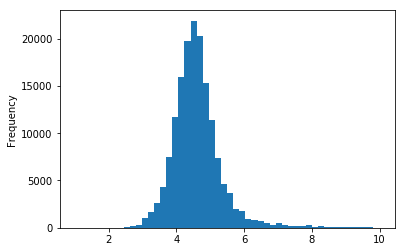

In [398]:
df[df.avg_word_len < 10].avg_word_len.plot(kind='hist', bins=50)

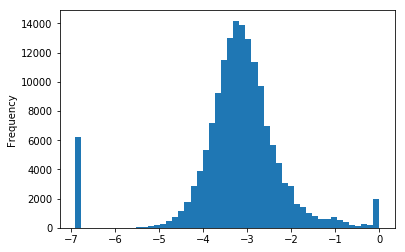

In [424]:
df.caps_percentage.apply(lambda x: np.log(x+0.001)).plot(kind='hist', bins=50)

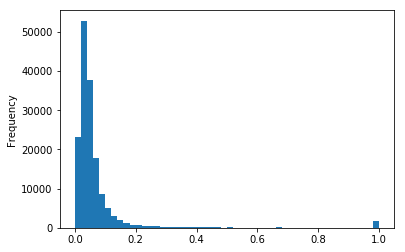

In [399]:
df.caps_percentage.plot(kind='hist', bins=50)

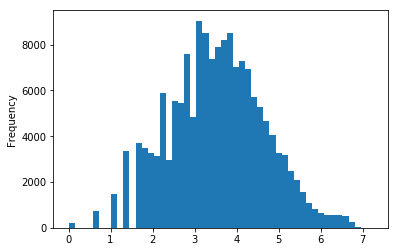

In [441]:
df.words.apply(lambda x: np.log(x)).plot(kind='hist', bins=50)

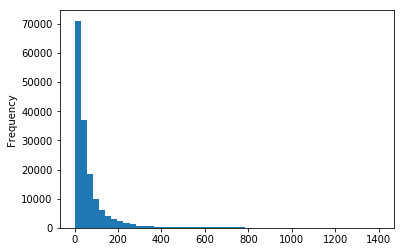

In [400]:
df.words.plot(kind='hist', bins=50)

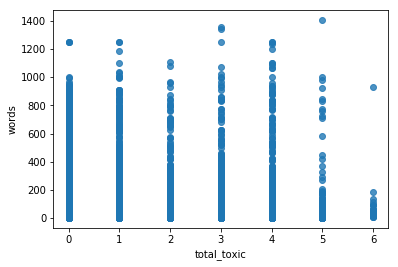

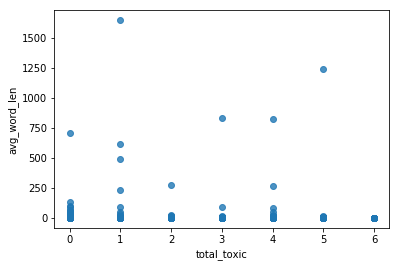

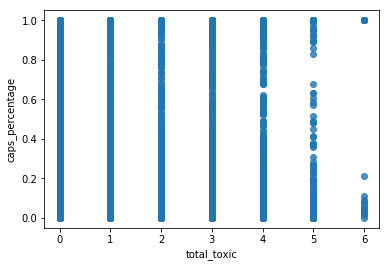

In [401]:
for y in ['words', 'avg_word_len', 'caps_percentage']:
    sns.regplot(x='total_toxic', y=y, data=df, fit_reg=False)
    plt.show()

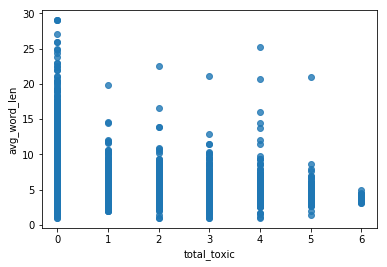

In [402]:
sns.regplot(x=df[df['avg_word_len']<30]['total_toxic'], y=df[df['avg_word_len']<30].avg_word_len, fit_reg=False)


In [403]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'total_toxic', 'is_toxic',
       'is_toxic_no_profanity', 'question', 'exclamation',
       'comment_text_char_only', 'comment_text_char_space', 'words',
       'avg_word_len', 'caps_percentage'],
      dtype='object')

In [404]:
df = df[['id', 'comment_text', 'comment_text_char_space',
    'comment_text_char_only', 'question', 'exclamation', 'words', 'avg_word_len', 'caps_percentage', 
    'toxic', 'severe_toxic', 'obscene', 'threat',
    'insult', 'identity_hate', 'total_toxic',  
    'is_toxic', 'is_toxic_no_profanity']]

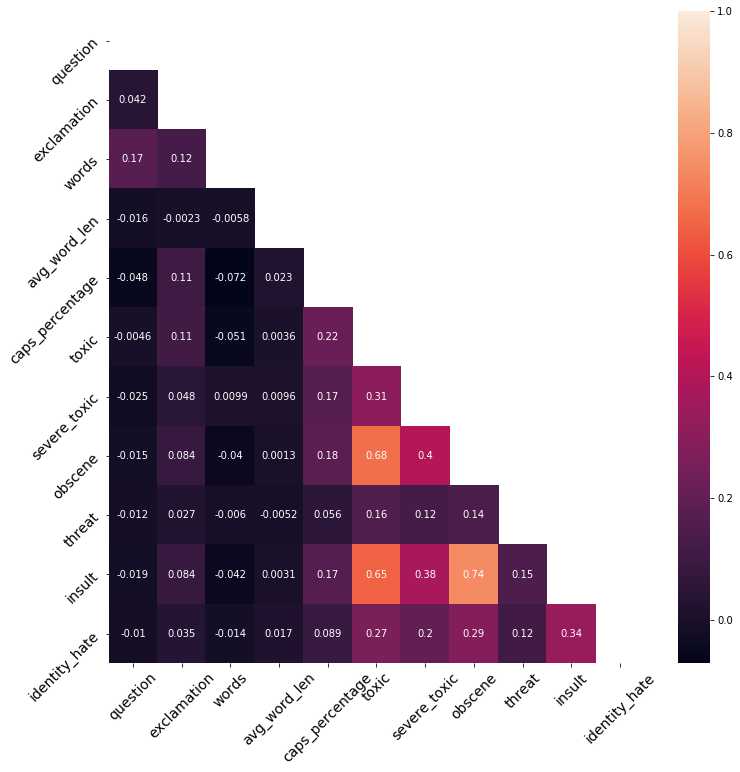

In [405]:
corr = df.drop(['is_toxic', 'total_toxic', 'is_toxic_no_profanity'], axis=1).corr()
# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(12,12))
# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corr, mask=mask, ax=ax, annot=True)
# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14 , rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14 , rotation=45)
# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

In [406]:
cv = CountVectorizer(stop_words='english')

In [407]:
toxic_text = cv.fit_transform(df[df.toxic == 1].comment_text_char_space)
toxic_words = list(zip(cv.get_feature_names(),np.array(toxic_text.sum(axis=0))[0]))
sorted(toxic_words, key=lambda x: x[1], reverse=True)[:5]

[('fuck', 8617),
 ('shit', 3586),
 ('dont', 3566),
 ('like', 3478),
 ('nigger', 3289)]

In [408]:
top_10 = []
for column in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    text = cv.fit_transform(df[df[column] == 1].comment_text)
    toxic_words = list(zip(cv.get_feature_names(),np.array(text.sum(axis=0))[0]))
    top_10.append((column, sorted(toxic_words, key=lambda x: x[1], reverse=True)[:10]))

In [409]:
top_10[:3]

[('toxic',
  [('fuck', 9934),
   ('wikipedia', 3678),
   ('shit', 3622),
   ('like', 3512),
   ('nigger', 3300),
   ('fucking', 3289),
   ('suck', 3235),
   ('ass', 2939),
   ('hate', 2631),
   ('don', 2569)]),
 ('severe_toxic',
  [('fuck', 7303),
   ('suck', 2535),
   ('ass', 2114),
   ('shit', 1884),
   ('faggot', 1571),
   ('fucking', 1456),
   ('die', 1156),
   ('bitch', 1113),
   ('nigger', 1012),
   ('sucks', 961)]),
 ('obscene',
  [('fuck', 9860),
   ('shit', 3212),
   ('fucking', 3192),
   ('suck', 3021),
   ('ass', 2846),
   ('nigger', 2727),
   ('wikipedia', 1905),
   ('bitch', 1795),
   ('like', 1541),
   ('cunt', 1530)])]

In [410]:
[i[0] for i in toxic[1]]

['nigger',
 'fat',
 'jew',
 'gay',
 'fuck',
 'die',
 'faggot',
 'fucking',
 'huge',
 'suck']

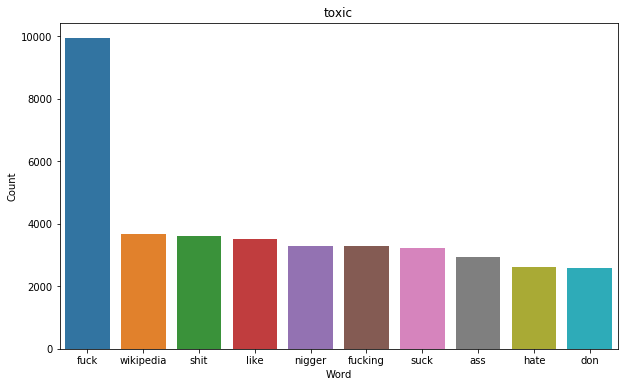

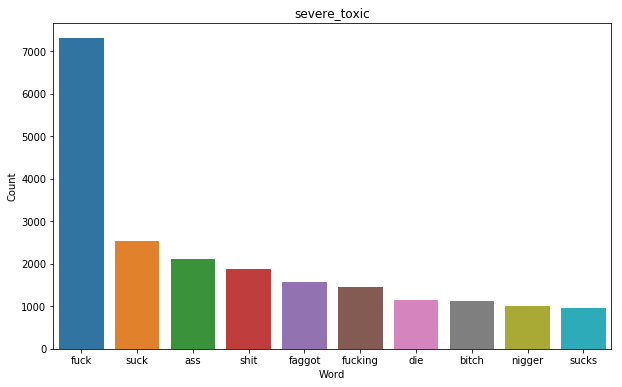

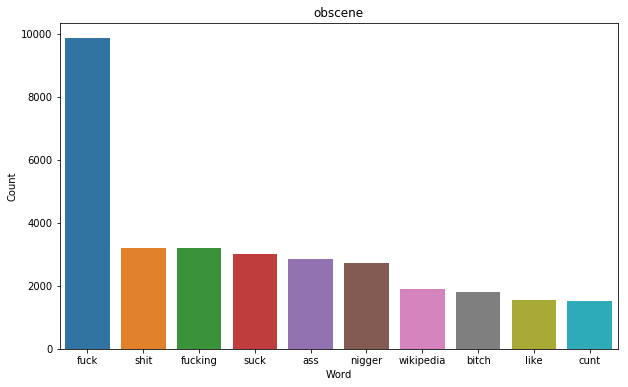

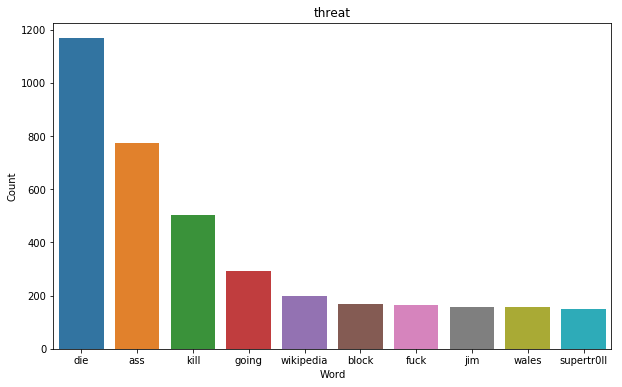

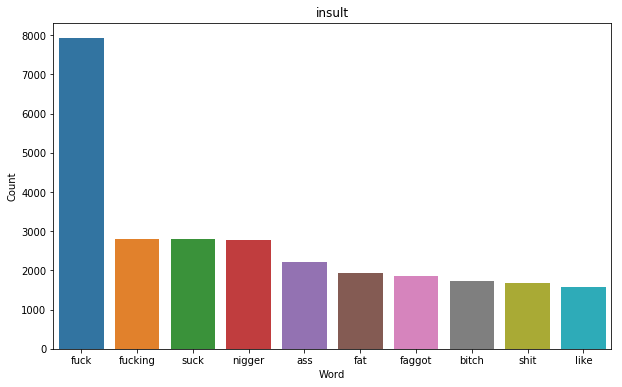

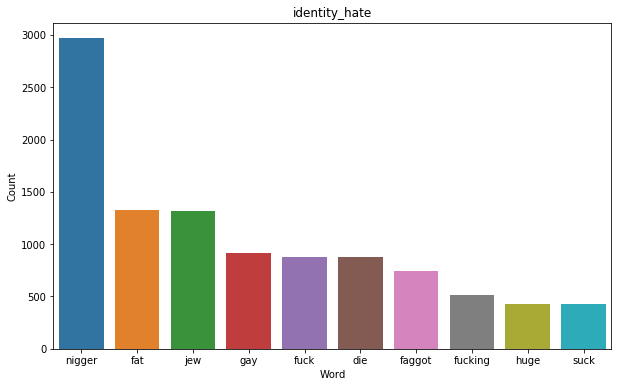

In [411]:
for toxic in top_10:
    plt.figure(figsize=(10,6))
    ax = sns.barplot(x=[i[0] for i in toxic[1]], y=[i[1] for i in toxic[1]])
    ax.set_title(toxic[0])
    ax.set_xlabel('Word')
    ax.set_ylabel('Count')
    plt.show()

In [412]:
# toxic_text = cv.fit_transform(df[df.toxic == 1].comment_text)
# toxic_words = list(zip(cv.get_feature_names(),np.array(toxic_text.sum(axis=0))[0]))
# sorted(toxic_words, key=lambda x: x[1], reverse=True)[:5]

In [413]:
df.columns

Index(['id', 'comment_text', 'comment_text_char_space',
       'comment_text_char_only', 'question', 'exclamation', 'words',
       'avg_word_len', 'caps_percentage', 'toxic', 'severe_toxic', 'obscene',
       'threat', 'insult', 'identity_hate', 'total_toxic', 'is_toxic',
       'is_toxic_no_profanity'],
      dtype='object')

In [414]:
df.shape

(159548, 18)

In [415]:
df.is_toxic.sum()

16225

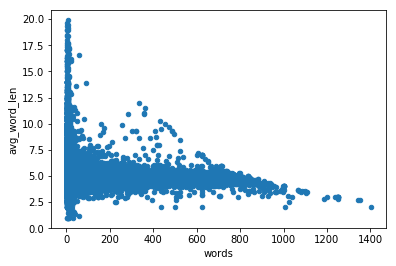

In [416]:
df[df.avg_word_len < 20].plot.scatter('words', 'avg_word_len')

In [417]:
# downsampling by removing the comments with low words until the number of toxic and non-toxic comments are the same

In [418]:
# commented out for now - potential bias in data

# for i in range(100,200):
#     if abs(df.is_toxic.sum() - (df[df.is_toxic == 0].words > i).sum()) < 300:
#         print('Number of words: ', i)
#         print('Difference: ', abs(df.is_toxic.sum() - (df[df.is_toxic == 0].words > i).sum()))

In [419]:
df[df.is_toxic == 0].sample(len(df[df.is_toxic == 0]) - df.is_toxic.sum(), random_state=322).index

Int64Index([ 96840,  21008,   7539, 105526,  60545, 136182,  84972,  92103,
             15272,   2837,
            ...
             49129, 103587,  98213, 138530, 114647, 152070,  42096, 153266,
              8249,  48484],
           dtype='int64', length=127098)

In [420]:
df.to_csv('cleaned.csv', index=False)

In [421]:
# df.to_csv('cleaned.csv', index=False)